# Let's read in our Exp005 FRAP data and generate some plots

In [ ]:
## TODO

- More consistent naming of measurements
- Better ROIs
- Tracking ROIs over time (how can we do this quickly?)


In [1]:
from os import listdir

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize

In [2]:
#Define the folder containing your file of interest,
#Currently this is './' the current folder
Exp005_folder = "C:/Users/David Brown/Documents/Huang Lab/EML4-ALK_FRAP_Exp005_Results/"

In [3]:
Exp005_files = listdir(Exp005_folder)
# Exp005_files

In [4]:
def getdata(input_folder, file_index):
    
    files = listdir(input_folder)
    file  = files[file_index]
    
    df = pd.read_csv(input_folder+file)

    names = list(df.columns)
    names[0]='Frame'
    names

    df.columns = names
    
    return df, file

In [5]:
#Read all the data into a list of dataframes.
#We really want one dataframe per focus, but we need to know which file each focus is from.


#Or one big dataframe (easier to save)

In [6]:
df_list = list()
file_list = list()

for file_index in range(len(Exp005_files)):

    df, file = getdata(Exp005_folder, file_index)

    df_list.append(df)
    file_list.append(file)

In [7]:
file_list

['EML4-ALKv1_Box_FRAP_03_Results.csv',
 'EML4-ALKv1_Box_FRAP_04_Results.csv',
 'EML4-ALKv1_Box_FRAP_06_Results.csv',
 'EML4-ALKv1_Box_FRAP_07_Results.csv',
 'EML4-ALKv1_Box_FRAP_08_Results.csv',
 'EML4-ALKv1_Box_FRAP_09_Results.csv',
 'EML4-ALKv3_Box_FRAP_02_Results.csv',
 'EML4-ALKv3_Box_FRAP_03_Results.csv',
 'EML4-ALKv3_Box_FRAP_05_Results.csv',
 'EML4-ALKv3_Box_FRAP_07_Results.csv']

In [8]:
def getFileInfo(filelist, **kwargs)->pd.DataFrame():
    """strip some information from the input file name"""
    
    #Get **kwargs
    search_list = kwargs.get('search_list', None)
    
    file_info = pd.DataFrame()
    
    #convert to lower case
    low_files = [file.lower() for file in filelist]
    
    file_info['File']     = range(len(filelist))
    file_info['ALKv1']    = ['alkv1'    in file for file in low_files]
    file_info['ALKv3']    = ['alkv3'    in file for file in low_files]
    file_info['ALKv5']    = ['alkv5'    in file for file in low_files]
    file_info['Ret']      = ['ret'      in file for file in low_files]
    
    if search_list is not None:
        
        for term in search_list:
            file_info[term] = [term.lower() in file for file in low_files]
    
    return file_info

In [9]:
file_info = getFileInfo(file_list, search_list = ['Fixed'])
file_info

,File,ALKv1,ALKv3,ALKv5,Ret,Fixed
0,0,True,False,False,False,False
1,1,True,False,False,False,False
2,2,True,False,False,False,False
3,3,True,False,False,False,False
4,4,True,False,False,False,False
5,5,True,False,False,False,False
6,6,False,True,False,False,False
7,7,False,True,False,False,False
8,8,False,True,False,False,False
9,9,False,True,False,False,False


In [10]:
def combineClassifiers(data, input_columns, output_column, drop=False):
    """Combine mutually exclusive input_columns into a single catagorical output column."""
    
    data[output_column] = data[input_columns].idxmax(axis=1)
    
    if drop:
        data.drop(columns=input_columns, inplace=True)
        
    return data

In [11]:
combineClassifiers(file_info, ['ALKv1','ALKv3','ALKv5','Ret'], 'Protein', drop=True)

,File,Fixed,Protein
0,0,False,ALKv1
1,1,False,ALKv1
2,2,False,ALKv1
3,3,False,ALKv1
4,4,False,ALKv1
5,5,False,ALKv1
6,6,False,ALKv3
7,7,False,ALKv3
8,8,False,ALKv3
9,9,False,ALKv3


In [12]:
file_info['Filename'] = file_list
file_info['fps'] = 1/5
file_info.loc[5, 'fps'] = 1
file_info

,File,Fixed,Protein,Filename,fps
0,0,False,ALKv1,EML4-ALKv1_Box_FRAP_03_Results.csv,0.2
1,1,False,ALKv1,EML4-ALKv1_Box_FRAP_04_Results.csv,0.2
2,2,False,ALKv1,EML4-ALKv1_Box_FRAP_06_Results.csv,0.2
3,3,False,ALKv1,EML4-ALKv1_Box_FRAP_07_Results.csv,0.2
4,4,False,ALKv1,EML4-ALKv1_Box_FRAP_08_Results.csv,0.2
5,5,False,ALKv1,EML4-ALKv1_Box_FRAP_09_Results.csv,1.0
6,6,False,ALKv3,EML4-ALKv3_Box_FRAP_02_Results.csv,0.2
7,7,False,ALKv3,EML4-ALKv3_Box_FRAP_03_Results.csv,0.2
8,8,False,ALKv3,EML4-ALKv3_Box_FRAP_05_Results.csv,0.2
9,9,False,ALKv3,EML4-ALKv3_Box_FRAP_07_Results.csv,0.2


In [13]:
#Get Bleach Frame

In [14]:
# Let's generate a list of t0 frames for these files.
t0_frames = [2]*len(file_list)

# We can edit the files with distinct t0 frames.

#EML4-ALKv1_Box_FRAP_09 t0 is 8, not 2 like everything else
t0_list=[2]*len(file_list)
t0_list[5] = 8

In [18]:
file_info['Bleach Frame'] = t0_list
file_info

,File,Fixed,Protein,Filename,fps,Bleach Frame
0,0,False,ALKv1,EML4-ALKv1_Box_FRAP_03_Results.csv,0.2,2
1,1,False,ALKv1,EML4-ALKv1_Box_FRAP_04_Results.csv,0.2,2
2,2,False,ALKv1,EML4-ALKv1_Box_FRAP_06_Results.csv,0.2,2
3,3,False,ALKv1,EML4-ALKv1_Box_FRAP_07_Results.csv,0.2,2
4,4,False,ALKv1,EML4-ALKv1_Box_FRAP_08_Results.csv,0.2,2
5,5,False,ALKv1,EML4-ALKv1_Box_FRAP_09_Results.csv,1.0,8
6,6,False,ALKv3,EML4-ALKv3_Box_FRAP_02_Results.csv,0.2,2
7,7,False,ALKv3,EML4-ALKv3_Box_FRAP_03_Results.csv,0.2,2
8,8,False,ALKv3,EML4-ALKv3_Box_FRAP_05_Results.csv,0.2,2
9,9,False,ALKv3,EML4-ALKv3_Box_FRAP_07_Results.csv,0.2,2


In [16]:
## File Info Looks Good ##

In [48]:
df = df_list[0]

In [49]:
df

,Frame,Mean(Focus),Mean(Spot),Mean(Bgd),Mean(FRAP_Box_1)
0,1,148.433,127.781,113.280,132.022
1,2,130.278,129.985,114.126,123.135
2,3,115.701,116.944,113.918,117.184
3,4,115.979,117.097,113.604,118.219
4,5,116.876,118.265,113.601,119.092
...,...,...,...,...,...
115,116,130.804,125.867,113.433,124.955
116,117,130.361,126.536,114.263,124.844
117,118,130.753,124.515,113.495,124.596
118,119,131.711,125.827,113.263,124.581


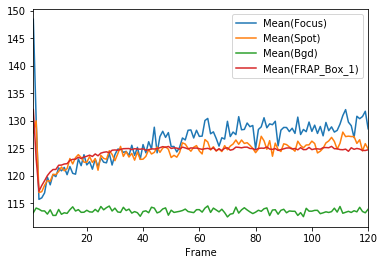

In [45]:
df.plot(x='Frame');

In [47]:
focus_list[0]

,Frame,Mean(Focus1),Mean(Spot1),Mean(Bgd)
0,1,NaN,NaN,113.280
1,2,NaN,NaN,114.126
2,3,NaN,NaN,113.918
3,4,NaN,NaN,113.604
4,5,NaN,NaN,113.601
...,...,...,...,...
115,116,NaN,NaN,113.433
116,117,NaN,NaN,114.263
117,118,NaN,NaN,113.495
118,119,NaN,NaN,113.263


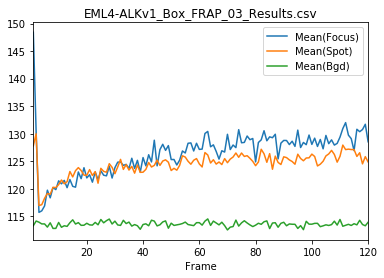

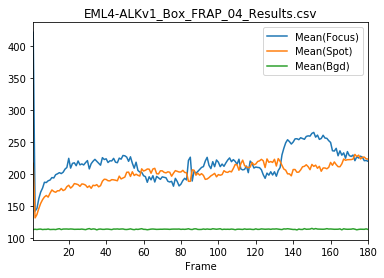

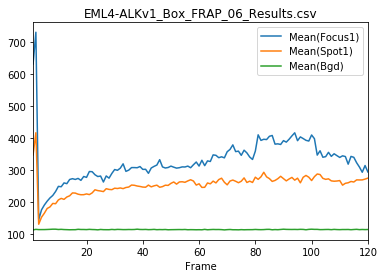

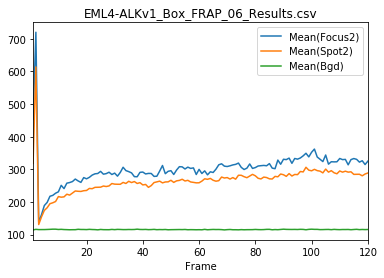

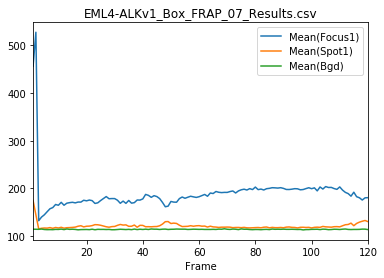

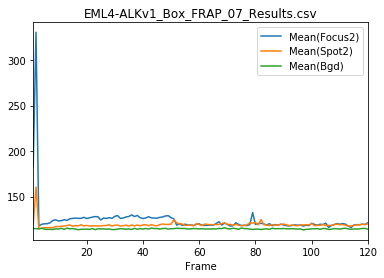

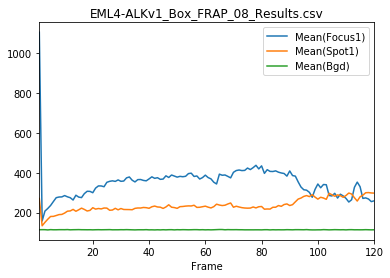

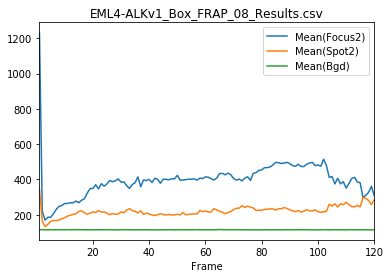

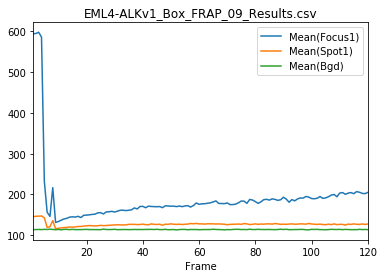

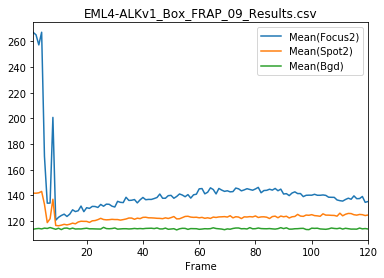

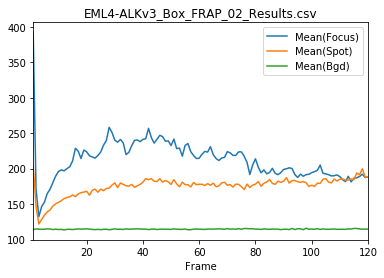

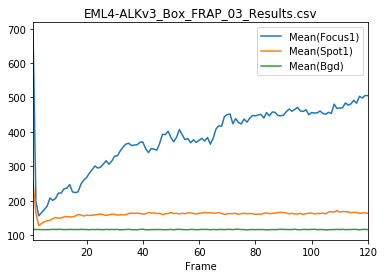

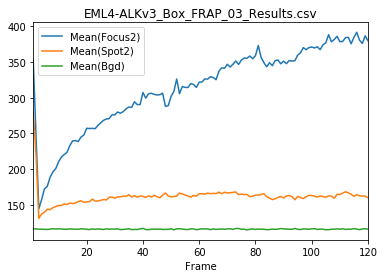

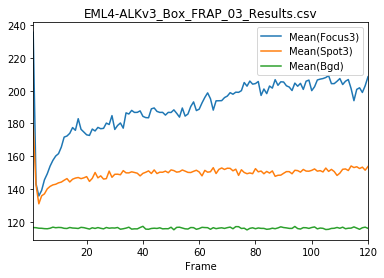

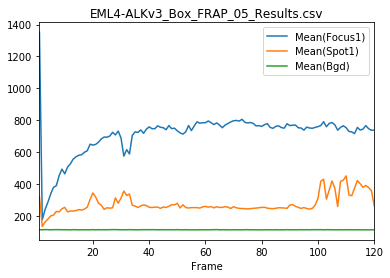

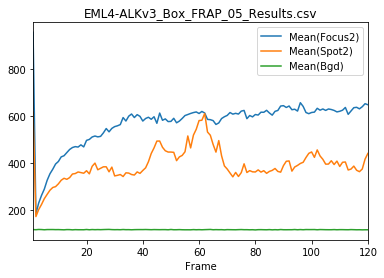

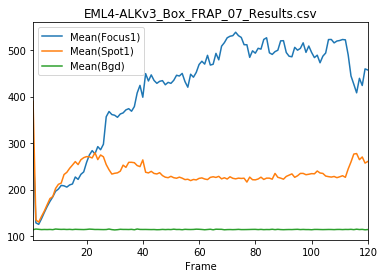

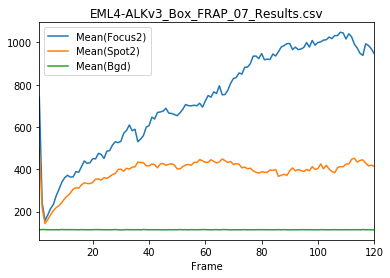

In [52]:
for index in range(len(focus_list)):
    
    df    = focus_list[index]
    title = focus_list_files[index]
    
    df.plot(x='Frame');
    plt.title(title);

In [50]:
focus_list = list()
focus_list_files = list()
focus_t0_list = list()

for i, df in enumerate(df_list):
#     print(i)

    if 'Mean(Focus2)' in df.columns:
        focus_list.append(df.loc[:,['Frame', 'Mean(Focus1)', 'Mean(Spot1)', 'Mean(Bgd)']])
        focus_list_files.append(file_list[i])
        focus_t0_list.append(t0_list[i])
        
        focus_list.append(df.loc[:,['Frame', 'Mean(Focus2)', 'Mean(Spot2)', 'Mean(Bgd)']])
        focus_list_files.append(file_list[i])
        focus_t0_list.append(t0_list[i])
        
    else:
        focus_list.append(df.loc[:,['Frame', 'Mean(Focus)', 'Mean(Spot)', 'Mean(Bgd)']])
        focus_list_files.append(file_list[i])
        focus_t0_list.append(t0_list[i])


    if 'Mean(Focus3)' in df.columns:
        focus_list.append(df.loc[:,['Frame', 'Mean(Focus3)', 'Mean(Spot3)', 'Mean(Bgd)']])
        focus_list_files.append(file_list[i])
        focus_t0_list.append(t0_list[i])
        
len(focus_list)

18

In [24]:
file_info

,File,Fixed,Protein,Filename,fps,Bleach Frame
0,0,False,ALKv1,EML4-ALKv1_Box_FRAP_03_Results.csv,0.2,2
1,1,False,ALKv1,EML4-ALKv1_Box_FRAP_04_Results.csv,0.2,2
2,2,False,ALKv1,EML4-ALKv1_Box_FRAP_06_Results.csv,0.2,2
3,3,False,ALKv1,EML4-ALKv1_Box_FRAP_07_Results.csv,0.2,2
4,4,False,ALKv1,EML4-ALKv1_Box_FRAP_08_Results.csv,0.2,2
5,5,False,ALKv1,EML4-ALKv1_Box_FRAP_09_Results.csv,1.0,8
6,6,False,ALKv3,EML4-ALKv3_Box_FRAP_02_Results.csv,0.2,2
7,7,False,ALKv3,EML4-ALKv3_Box_FRAP_03_Results.csv,0.2,2
8,8,False,ALKv3,EML4-ALKv3_Box_FRAP_05_Results.csv,0.2,2
9,9,False,ALKv3,EML4-ALKv3_Box_FRAP_07_Results.csv,0.2,2


In [25]:
focus_list_files

['EML4-ALKv1_Box_FRAP_03_Results.csv',
 'EML4-ALKv1_Box_FRAP_04_Results.csv',
 'EML4-ALKv1_Box_FRAP_06_Results.csv',
 'EML4-ALKv1_Box_FRAP_06_Results.csv',
 'EML4-ALKv1_Box_FRAP_07_Results.csv',
 'EML4-ALKv1_Box_FRAP_07_Results.csv',
 'EML4-ALKv1_Box_FRAP_08_Results.csv',
 'EML4-ALKv1_Box_FRAP_08_Results.csv',
 'EML4-ALKv1_Box_FRAP_09_Results.csv',
 'EML4-ALKv1_Box_FRAP_09_Results.csv',
 'EML4-ALKv3_Box_FRAP_02_Results.csv',
 'EML4-ALKv3_Box_FRAP_03_Results.csv',
 'EML4-ALKv3_Box_FRAP_03_Results.csv',
 'EML4-ALKv3_Box_FRAP_03_Results.csv',
 'EML4-ALKv3_Box_FRAP_05_Results.csv',
 'EML4-ALKv3_Box_FRAP_05_Results.csv',
 'EML4-ALKv3_Box_FRAP_07_Results.csv',
 'EML4-ALKv3_Box_FRAP_07_Results.csv']

In [84]:
focus_file_info = list()

for file in focus_list_files:
    focus_file_info.append(file_info[file_info.Filename==file])
focus_file_info = pd.concat(focus_file_info, axis=0)

focus_file_info.reset_index(inplace=True, drop=True)
focus_file_info

,File,Fixed,Protein,Filename,fps,Bleach Frame
0,0,False,ALKv1,EML4-ALKv1_Box_FRAP_03_Results.csv,0.2,2
1,1,False,ALKv1,EML4-ALKv1_Box_FRAP_04_Results.csv,0.2,2
2,2,False,ALKv1,EML4-ALKv1_Box_FRAP_06_Results.csv,0.2,2
3,2,False,ALKv1,EML4-ALKv1_Box_FRAP_06_Results.csv,0.2,2
4,3,False,ALKv1,EML4-ALKv1_Box_FRAP_07_Results.csv,0.2,2
5,3,False,ALKv1,EML4-ALKv1_Box_FRAP_07_Results.csv,0.2,2
6,4,False,ALKv1,EML4-ALKv1_Box_FRAP_08_Results.csv,0.2,2
7,4,False,ALKv1,EML4-ALKv1_Box_FRAP_08_Results.csv,0.2,2
8,5,False,ALKv1,EML4-ALKv1_Box_FRAP_09_Results.csv,1.0,8
9,5,False,ALKv1,EML4-ALKv1_Box_FRAP_09_Results.csv,1.0,8


In [22]:
#Convert to frap.

In [36]:
def prebleach(df):
    
    #choose the first measurement as the prebleach condition 'pre'
    pre = df.iloc[0,1:]
    pre = pd.DataFrame(pre).T
    
    return pre

In [37]:
def subtract_background(df):
    
    #subtract the background column
    sub = df.subtract(df['Mean(Bgd)'], axis=0)
    sub.Frame = df.Frame
    sub.drop(columns='Mean(Bgd)', inplace=True)
    return sub

In [38]:
def normalise(sub):
    
    pre = prebleach(sub)
    
    norm = pd.DataFrame()

    for key, value in pre.to_dict(orient='index')[0].items():
    #     print(key, value)

        norm[str(key)] = sub.loc[:, key].divide(value)

    norm['Frame'] = sub['Frame']
    
    return norm

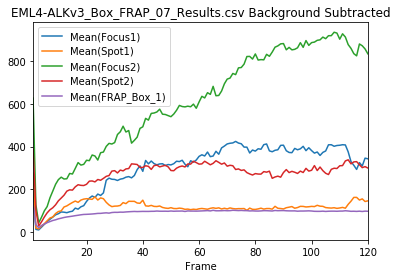

In [39]:
sub = subtract_background(df)

sub.plot(x='Frame');
plt.title(title+' Background Subtracted');

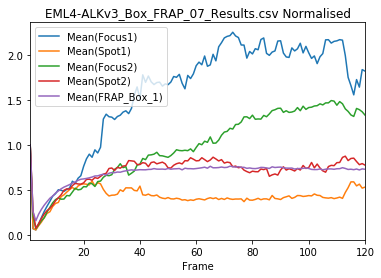

In [40]:
norm = normalise(sub)

norm.plot(x='Frame');
plt.title(title+' Normalised');

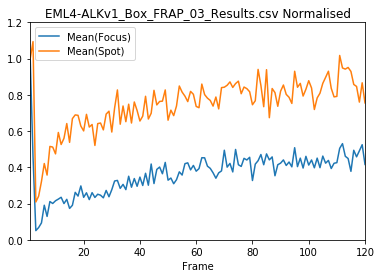

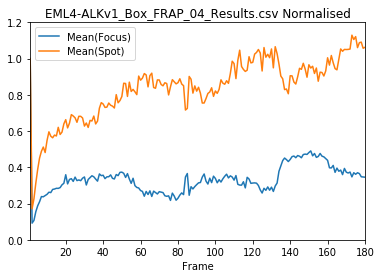

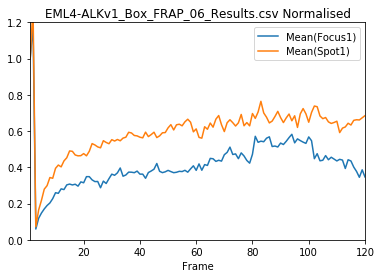

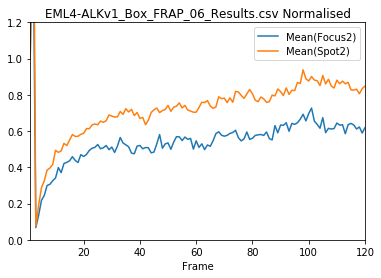

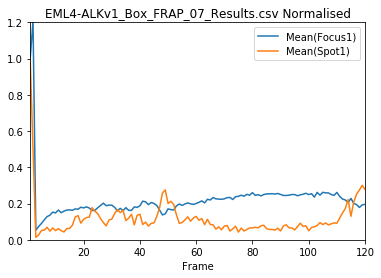

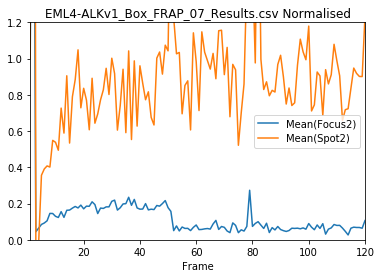

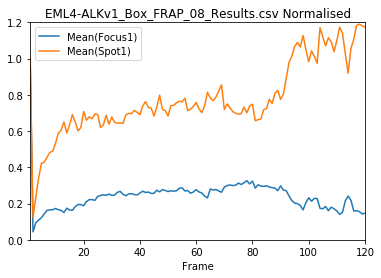

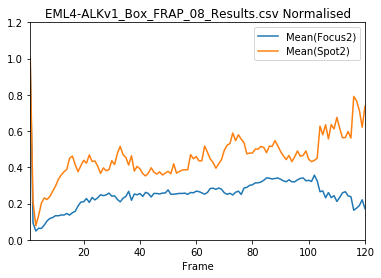

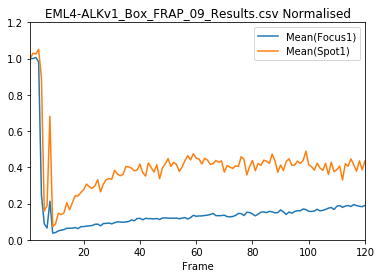

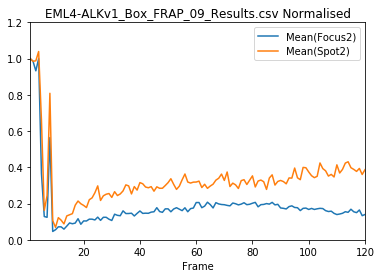

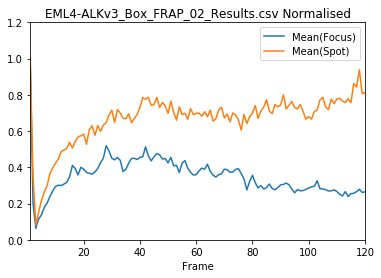

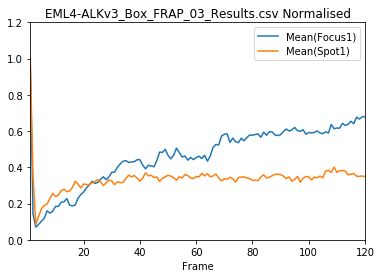

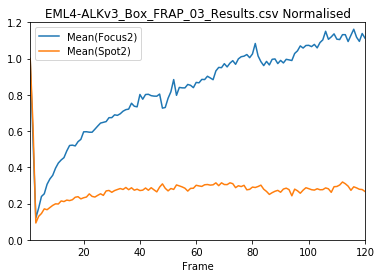

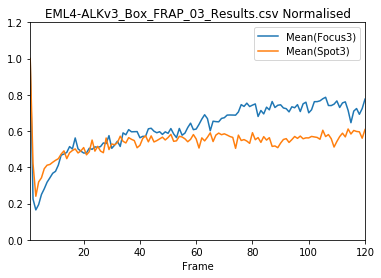

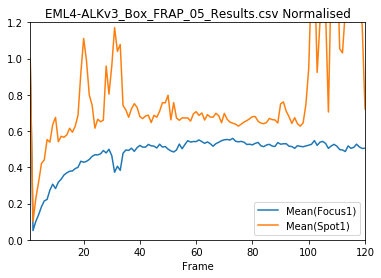

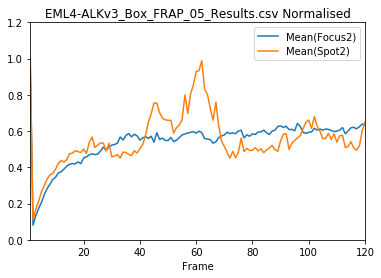

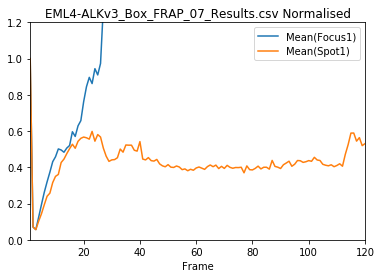

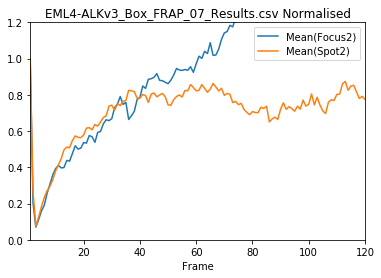

In [53]:
for index in range(len(focus_list)):
    
    df    = focus_list[index]
    title = focus_list_files[index]
        
    sub = subtract_background(df)
    norm = normalise(sub)

    norm.plot(x='Frame');
    plt.title(title+' Normalised');
    plt.ylim(0,1.2);

In [54]:
#Get the timescales right.
def set_time(df, fps):
    
    df['Time'] = (df.Frame - 2)*1/fps

In [56]:
set_time(df, 0.2)

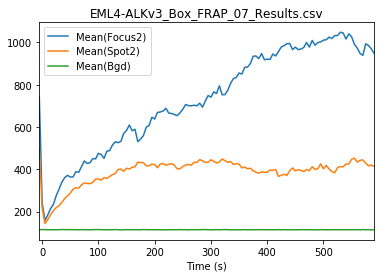

In [57]:
df.drop(columns=['Frame']).plot(x='Time');
plt.title(title);
plt.xlabel('Time (s)');

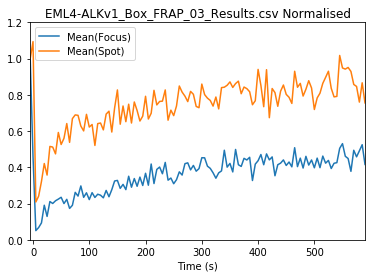

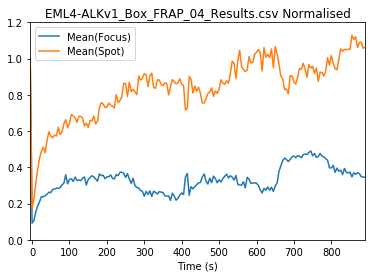

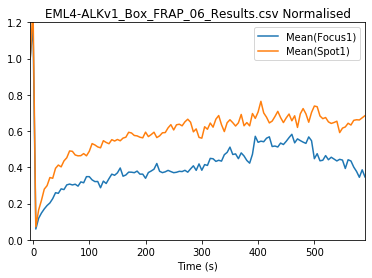

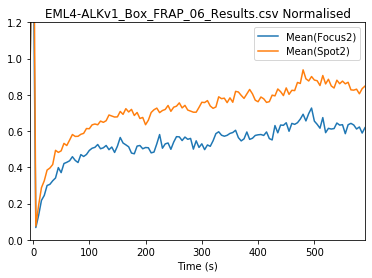

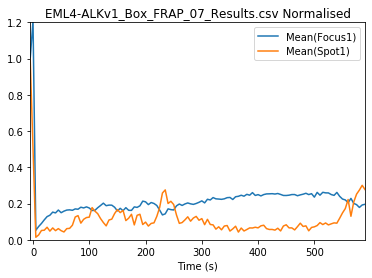

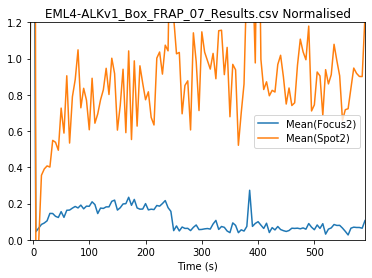

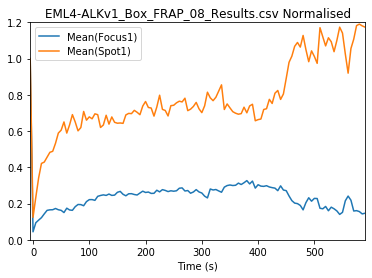

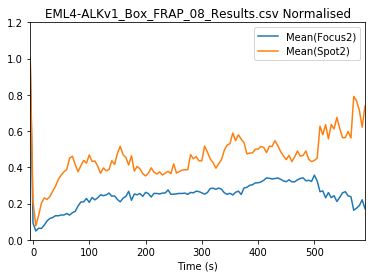

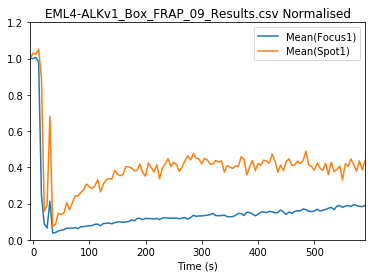

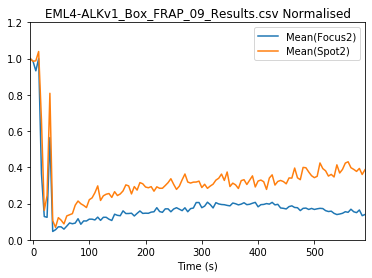

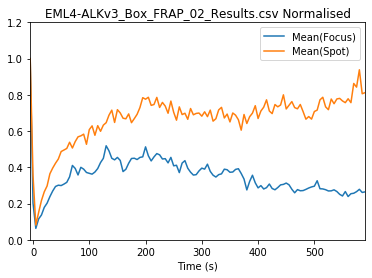

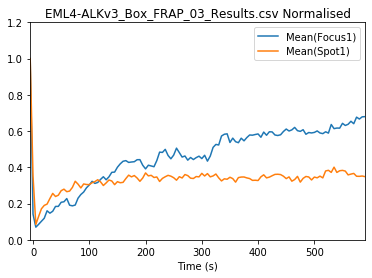

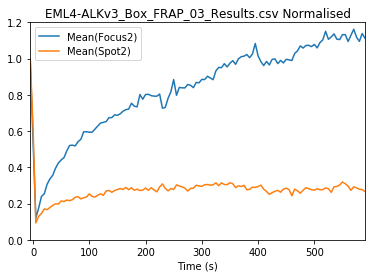

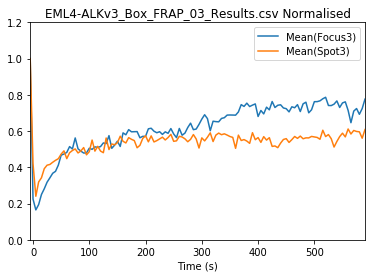

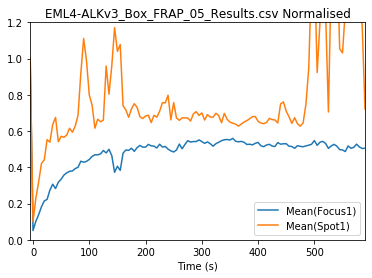

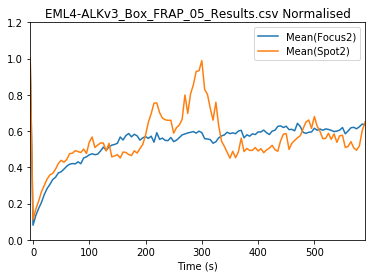

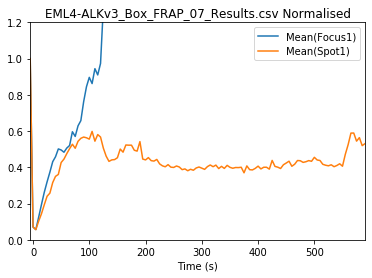

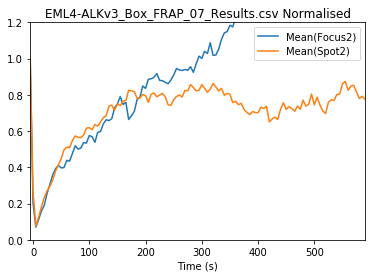

In [58]:
for index in range(len(focus_list)):
    
    df    = focus_list[index]
    title = focus_list_files[index]
    
    sub = subtract_background(df)
    norm = normalise(sub)
    
    set_time(norm, file_info.loc[file_index, 'fps'])

    norm.drop(columns=['Frame']).plot(x='Time');
    plt.title(title+' Normalised');
    plt.ylim(0,1.2);
    plt.xlabel('Time (s)');

In [33]:
#EML4-ALKv1_Box_FRAP_03  and
#EML4-ALKv3_Box_FRAP_02
#Have less mobility problems.

In [73]:
norm

,Mean(Focus1),Mean(Spot1),Frame,Time
0,1.000000,1.000000,1,-5.0
1,1.187752,1.288607,2,0.0
2,0.059396,0.071843,3,5.0
3,0.118867,0.164705,4,10.0
4,0.147665,0.217783,5,15.0
...,...,...,...,...
115,0.401295,0.659284,116,570.0
116,0.377127,0.662565,117,575.0
117,0.344960,0.661281,118,580.0
118,0.386161,0.673309,119,585.0


In [35]:
norm[norm['Time']==60]

,Mean(Focus1),Mean(Spot1),Mean(Focus2),Mean(Spot2),Mean(FRAP_Box_1),Time,Frame
13,0.506229,0.475473,0.437932,0.511568,0.544518,60.0,14


In [36]:
norm[norm['Time']==300]

,Mean(Focus1),Mean(Spot1),Mean(Focus2),Mean(Spot2),Mean(FRAP_Box_1),Time,Frame
61,1.888466,0.395361,1.001331,0.856725,0.745655,300.0,62


In [37]:
norm[norm['Time']==540]

,Mean(Focus1),Mean(Spot1),Mean(Focus2),Mean(Spot2),Mean(FRAP_Box_1),Time,Frame
109,2.153952,0.410136,1.439544,0.802301,0.734658,540.0,110


In [74]:
def get_FRAP(norm, t0):
    
    FRAP = norm[t0:].copy()
#     FRAP['Time'] = (FRAP['Frame']-t0)
    
    return FRAP

In [75]:
FRAP = get_FRAP(norm, 1)
FRAP

,Mean(Focus1),Mean(Spot1),Frame,Time
1,1.187752,1.288607,2,0.0
2,0.059396,0.071843,3,5.0
3,0.118867,0.164705,4,10.0
4,0.147665,0.217783,5,15.0
5,0.170380,0.279531,6,20.0
...,...,...,...,...
115,0.401295,0.659284,116,570.0
116,0.377127,0.662565,117,575.0
117,0.344960,0.661281,118,580.0
118,0.386161,0.673309,119,585.0


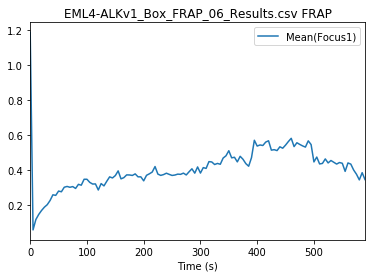

In [76]:
FRAP.drop(columns=['Frame']).plot(x='Time', y='Mean(Focus1)');
plt.title(title+' FRAP');
plt.xlabel('Time (s)');

In [41]:
# Fit the curves

In [62]:
def exp_curve(x, A, c, h):
    
    y = h - A*(np.exp(-x/c))
    
    return y

In [63]:
def bi_exp_curve(x, A, B, c, d, h):
    
    y = h - A*(np.exp(-x/c))-B*(np.exp(-x/d))
    
    return y

In [64]:
def fit_exp(x, y0, p0, bounds):

    p , e = optimize.curve_fit(f = exp_curve, xdata=x, ydata=y0, p0=p0, bounds=bounds)

    A, c, h = p

    fit = exp_curve(x, A, c, h)

    return fit, p, e

In [65]:
# Fit bi exp
def fit_bi_exp(x, y0, initial_parameters, bounds):

    parameters, error = optimize.curve_fit(f = bi_exp_curve, xdata=x, ydata=y0, p0=initial_parameters, bounds=bounds)

    A, B, c, d, h = parameters

    fit = bi_exp_curve(x, A, B, c, d, h)
    
    return fit, parameters , error

In [66]:
# Compare fits
def compare_fits(x, y0):
       
    plt.scatter(x, y0, s=3, c='dimgrey');

    A= 0.7
    c= 0.6
    h= 0.24

    p0 = [A, c, h]
    bounds = (0.1, 0.1, 0), (1, 90, 1)

    y1, p, e = fit_exp(x, y0, p0, bounds)

    plt.plot(x, y1, c='b');

    p0 = [A, B, c, d, h]
    bounds = (0.1, 0.01, 0, 0, 0.01), (1, 1, 100, 100, 1)

    y2, p, e = fit_bi_exp(x, y0, p0, bounds)

    plt.plot(x, y2, c='r');

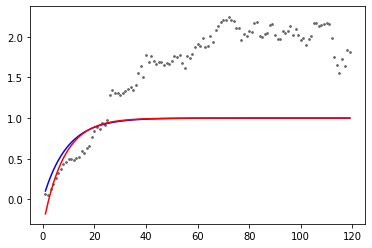

In [49]:
compare_fits(x, y0)

In [88]:
file_info

,File,Fixed,Protein,Filename,fps,Bleach Frame
0,0,False,ALKv1,EML4-ALKv1_Box_FRAP_03_Results.csv,0.2,2
1,1,False,ALKv1,EML4-ALKv1_Box_FRAP_04_Results.csv,0.2,2
2,2,False,ALKv1,EML4-ALKv1_Box_FRAP_06_Results.csv,0.2,2
3,3,False,ALKv1,EML4-ALKv1_Box_FRAP_07_Results.csv,0.2,2
4,4,False,ALKv1,EML4-ALKv1_Box_FRAP_08_Results.csv,0.2,2
5,5,False,ALKv1,EML4-ALKv1_Box_FRAP_09_Results.csv,1.0,8
6,6,False,ALKv3,EML4-ALKv3_Box_FRAP_02_Results.csv,0.2,2
7,7,False,ALKv3,EML4-ALKv3_Box_FRAP_03_Results.csv,0.2,2
8,8,False,ALKv3,EML4-ALKv3_Box_FRAP_05_Results.csv,0.2,2
9,9,False,ALKv3,EML4-ALKv3_Box_FRAP_07_Results.csv,0.2,2


In [89]:
focus_file_info

,File,Fixed,Protein,Filename,fps,Bleach Frame
0,0,False,ALKv1,EML4-ALKv1_Box_FRAP_03_Results.csv,0.2,2
1,1,False,ALKv1,EML4-ALKv1_Box_FRAP_04_Results.csv,0.2,2
2,2,False,ALKv1,EML4-ALKv1_Box_FRAP_06_Results.csv,0.2,2
3,2,False,ALKv1,EML4-ALKv1_Box_FRAP_06_Results.csv,0.2,2
4,3,False,ALKv1,EML4-ALKv1_Box_FRAP_07_Results.csv,0.2,2
5,3,False,ALKv1,EML4-ALKv1_Box_FRAP_07_Results.csv,0.2,2
6,4,False,ALKv1,EML4-ALKv1_Box_FRAP_08_Results.csv,0.2,2
7,4,False,ALKv1,EML4-ALKv1_Box_FRAP_08_Results.csv,0.2,2
8,5,False,ALKv1,EML4-ALKv1_Box_FRAP_09_Results.csv,1.0,8
9,5,False,ALKv1,EML4-ALKv1_Box_FRAP_09_Results.csv,1.0,8


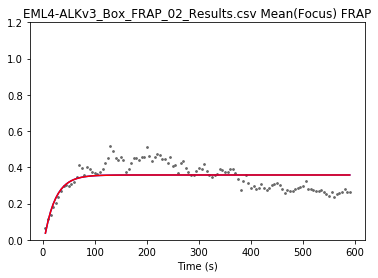

In [78]:
#What about when I change the df?
file_index = 6
column = 0

df    = df_list[file_index]
title = file_list[file_index]
t0    = focus_file_info.loc[file_index, 'Bleach Frame']

sub = subtract_background(df)
norm = normalise(sub)

set_time(norm, file_info.loc[file_index, 'fps'])

FRAP = get_FRAP(norm, t0)

column_name = FRAP.columns[column]

x = FRAP['Time']
y0 = FRAP.iloc[:,column]

compare_fits(x, y0)
plt.title(title+' '+column_name+' FRAP');
plt.ylim(0,1.2);
plt.xlabel('Time (s)');

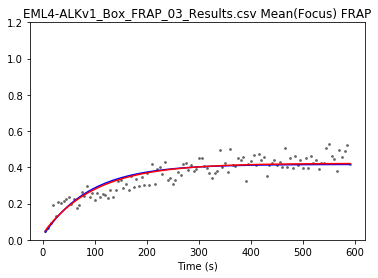

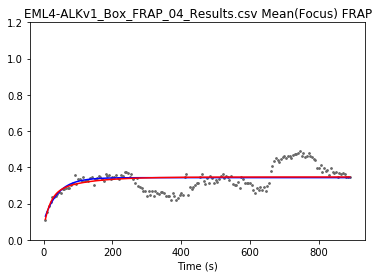

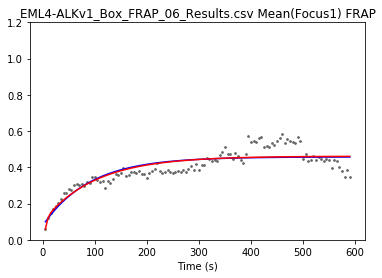

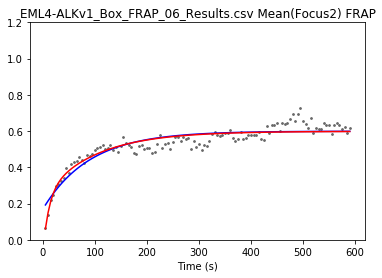

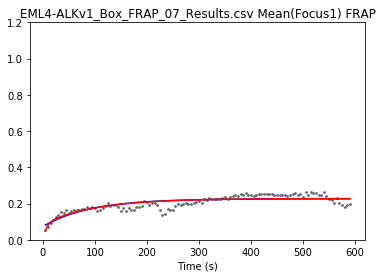

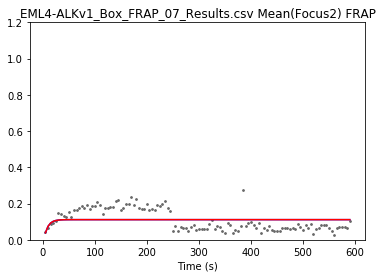

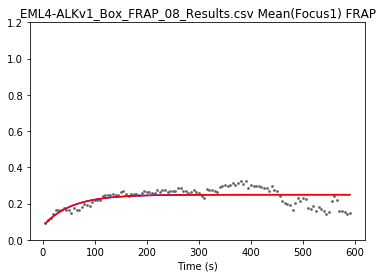

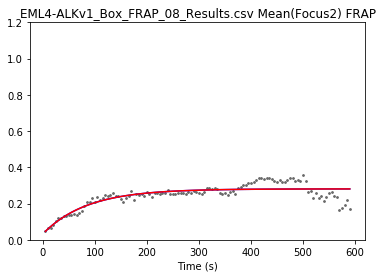

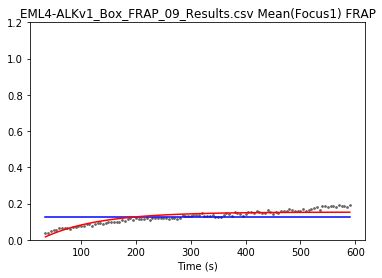

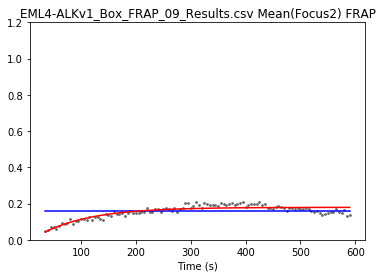

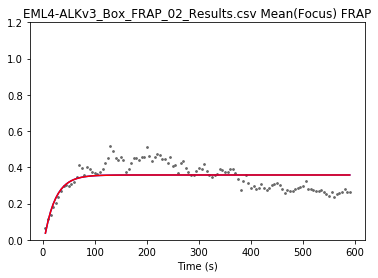

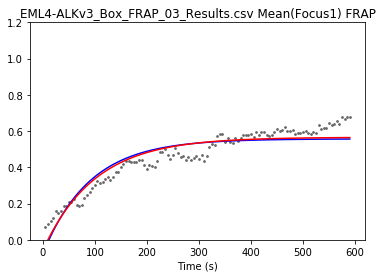

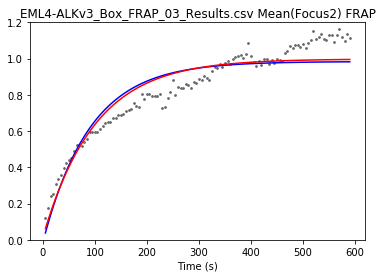

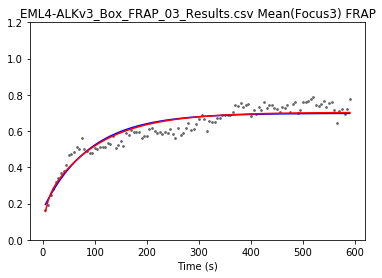

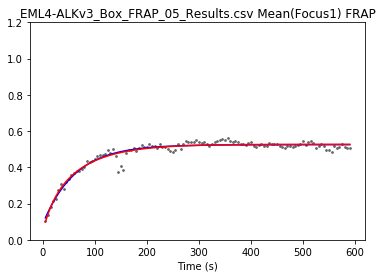

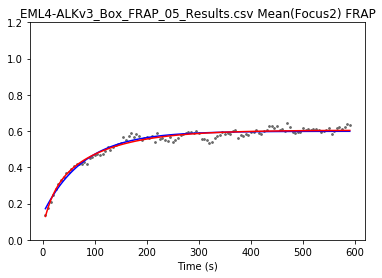

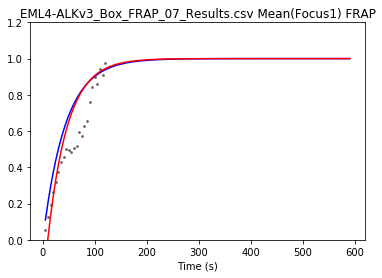

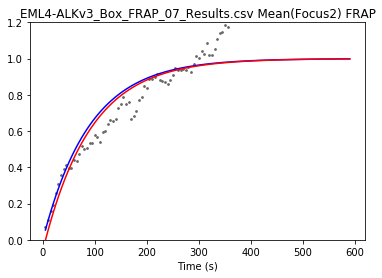

In [86]:
#Plot all the foci
column = 0
    
for index in range(len(focus_list)):
    
    df    = focus_list[index]
    title = focus_list_files[index]
    t0    = focus_file_info.loc[index, 'Bleach Frame']
    
    sub = subtract_background(df)
    norm = normalise(sub)

    set_time(norm, focus_file_info.loc[file_index, 'fps'])

    FRAP = get_FRAP(norm, t0)

    column_name = FRAP.columns[column]

    x = FRAP['Time']
    y0 = FRAP.iloc[:,column]

    compare_fits(x, y0)
    plt.title(title+' '+column_name+' FRAP');
    plt.ylim(0,1.2);
    plt.xlabel('Time (s)');
    plt.show()

In [87]:
# How do I get the estimated Mobile Fractions for each plot?
def get_mobile_from_fit(y1):
    
    v  = y1.max()
    print('v = ', v)
    F0 = y1.min()
    print('F0 = ', F0)
    M  = (v - F0)/(1-F0)
    
    return M

v =  0.4207527330995783
F0 =  0.05266057084627762


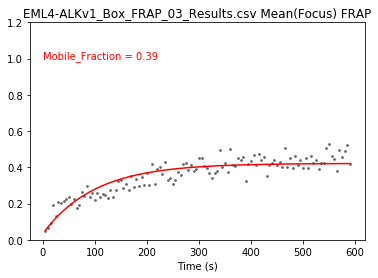

v =  0.34963215072189846
F0 =  0.20349365709710934


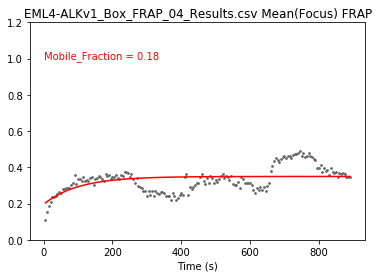

v =  0.46134557990347674
F0 =  0.11047422004748347


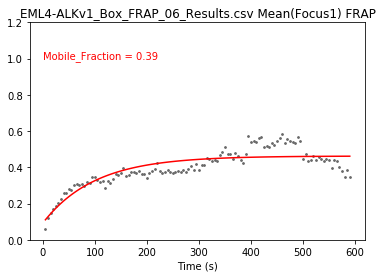

v =  0.5976216863402055
F0 =  0.060790582355844114


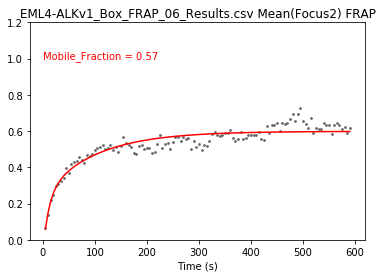

v =  0.22817562283357345
F0 =  0.08515133172270298


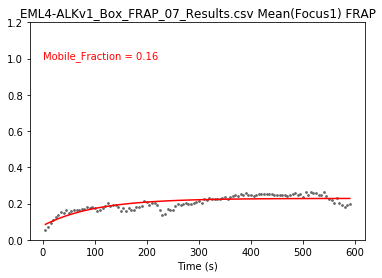

v =  0.11126445028571842
F0 =  0.03836955122692402


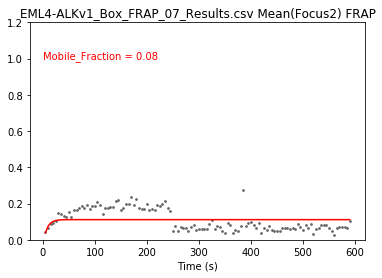

v =  0.24891604072837514
F0 =  0.09047570669135174


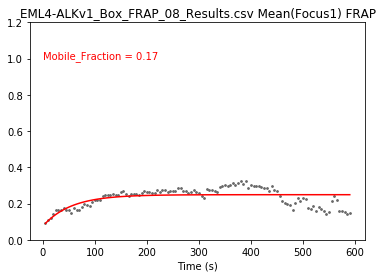

v =  0.2807504511889821
F0 =  0.046740802829665196


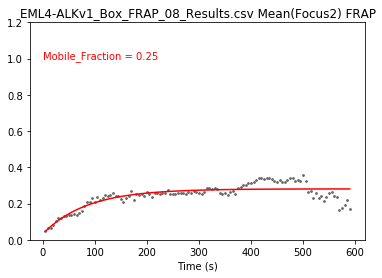

v =  0.15229546071231043
F0 =  0.016279240438035608


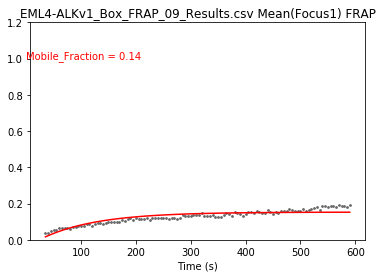

v =  0.1789009165919271
F0 =  0.04266305273119855


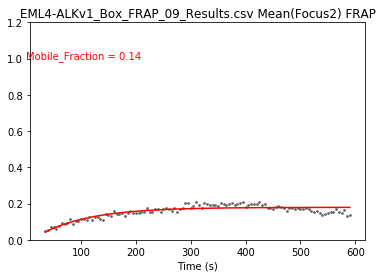

v =  0.35767586644228255
F0 =  0.03664595267214526


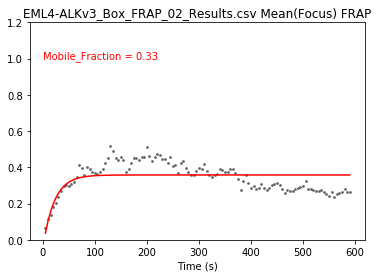

v =  0.5642172785350541
F0 =  -0.028018397858303734


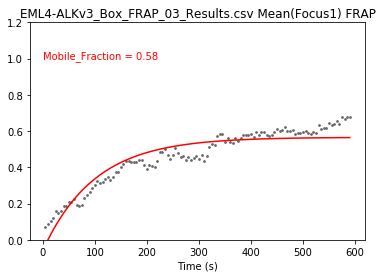

v =  0.9951970906522446
F0 =  0.06169253246391526


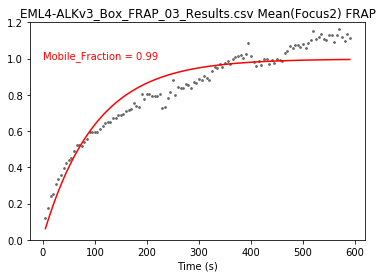

v =  0.7022961666086565
F0 =  0.1564314201319022


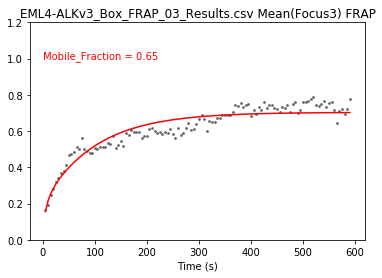

v =  0.526858599953534
F0 =  0.0992014446878357


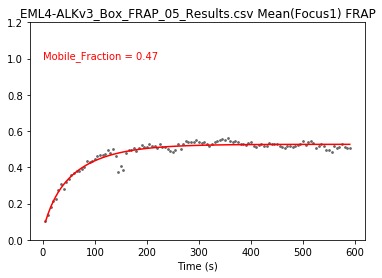

v =  0.6036916460729195
F0 =  0.12896564695571855


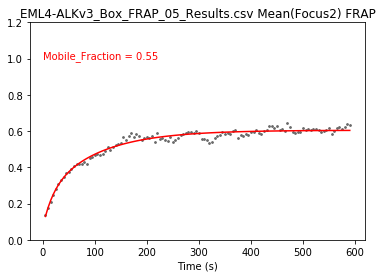

v =  0.9999997549084823
F0 =  -0.12560174596312612


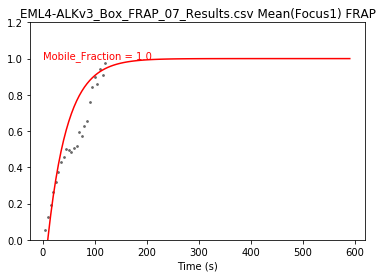

v =  0.9983706956993588
F0 =  -0.002445954134930206


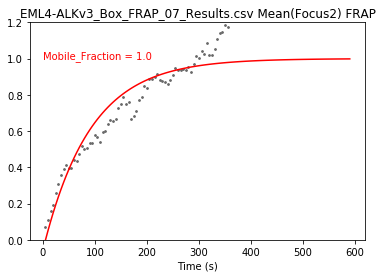

In [90]:
# Biexponentials fit a bit better

M_list = list()
column = 0

#Plot all the files
for index in range(len(focus_list)):

    df    = focus_list[index]
    title = focus_list_files[index]
    t0    = focus_file_info.loc[index, 'Bleach Frame']

    sub = subtract_background(df)
    norm = normalise(sub)

    set_time(norm, focus_file_info.loc[file_index, 'fps'])

    FRAP = get_FRAP(norm, t0)


    column_name = FRAP.columns[column]

    x = FRAP['Time']
    y0 = FRAP.iloc[:,column]

    #Plot raw values
    plt.scatter(x, y0, s=3, c='dimgrey');
    
    p0 = [A, B, c, d, h]
    bounds = (0.1, 0.01, 0, 0, 0.01), (1, 1, 100, 100, 1)
    
    y2, p, e = fit_bi_exp(x, y0, p0, bounds)
    
    #Plot fit values
    plt.plot(x, y2, c='r');
    
    #Get Mobile Fraction Estimate
    Mobile_Fraction = get_mobile_from_fit(y2)
    
    M_list.append(Mobile_Fraction)
    
    plt.text(0, 1, s='Mobile_Fraction = '+str(round(Mobile_Fraction, 2)), c='r');
    
    plt.title(title+' '+column_name+' FRAP');
    plt.ylim(0,1.2);
    plt.xlabel('Time (s)');
    plt.show()

In [106]:
focus_file_info['Focus Mobile Fraction'] = M_list
focus_file_info

,File,Fixed,Protein,Filename,fps,Bleach Frame,Focus Mobile Fraction
0,0,False,ALKv1,EML4-ALKv1_Box_FRAP_03_Results.csv,0.2,2,0.388554
1,1,False,ALKv1,EML4-ALKv1_Box_FRAP_04_Results.csv,0.2,2,0.183474
2,2,False,ALKv1,EML4-ALKv1_Box_FRAP_06_Results.csv,0.2,2,0.394448
3,2,False,ALKv1,EML4-ALKv1_Box_FRAP_06_Results.csv,0.2,2,0.571578
4,3,False,ALKv1,EML4-ALKv1_Box_FRAP_07_Results.csv,0.2,2,0.156337
5,3,False,ALKv1,EML4-ALKv1_Box_FRAP_07_Results.csv,0.2,2,0.075803
6,4,False,ALKv1,EML4-ALKv1_Box_FRAP_08_Results.csv,0.2,2,0.174201
7,4,False,ALKv1,EML4-ALKv1_Box_FRAP_08_Results.csv,0.2,2,0.245484
8,5,False,ALKv1,EML4-ALKv1_Box_FRAP_09_Results.csv,1.0,8,0.138267
9,5,False,ALKv1,EML4-ALKv1_Box_FRAP_09_Results.csv,1.0,8,0.142309


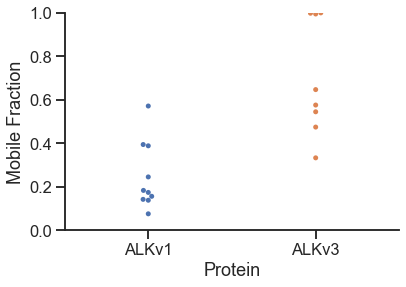

In [97]:
#If you have seaborn
import seaborn as sns

sns.set(style='ticks', context='talk')

sns.swarmplot('Protein', 'Mobile Fraction', data=focus_file_info)
sns.despine()
plt.ylim(0,1);

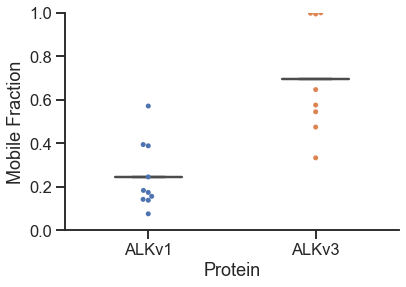

In [100]:
sns.boxplot('Protein', 'Mobile Fraction', data=focus_file_info.groupby(by='Protein').mean().reset_index(), width=0.4)
sns.swarmplot('Protein', 'Mobile Fraction', data=focus_file_info)
sns.despine()
plt.ylim(0,1);
plt.ylabel('Mobile Fraction');

v =  0.824549569226689
F0 =  0.18522452751233676


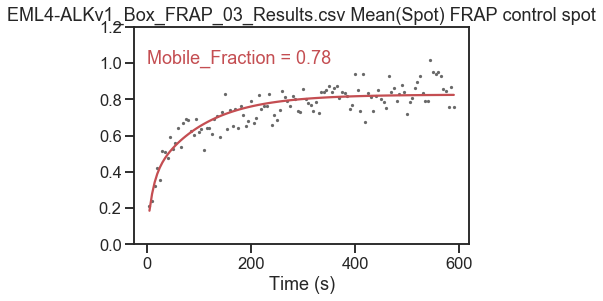

v =  0.9148467439834617
F0 =  0.2271562678984148


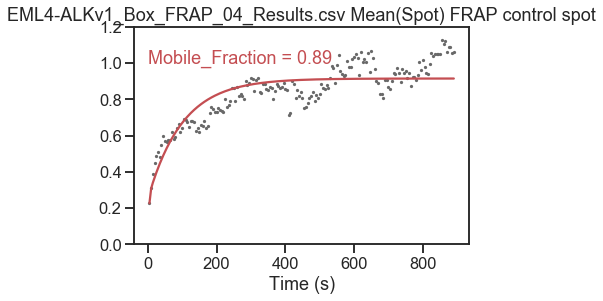

v =  0.6602562159616475
F0 =  0.06813574157743502


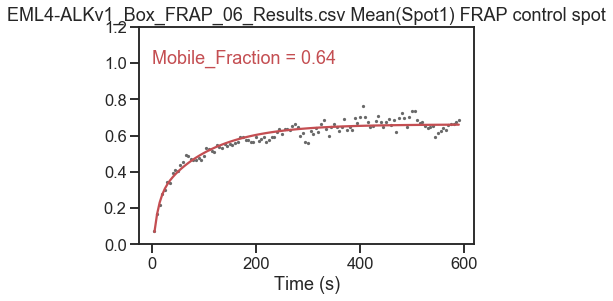

v =  0.8107107350606193
F0 =  0.07115217071878577


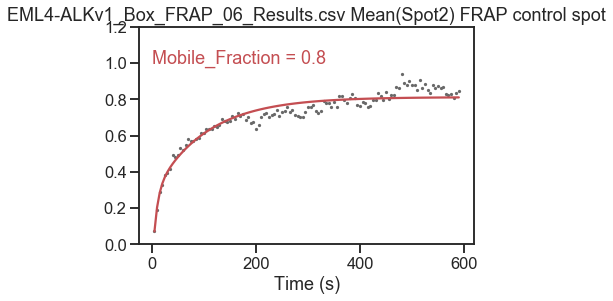

v =  0.11096942301262647
F0 =  0.00907716398198287


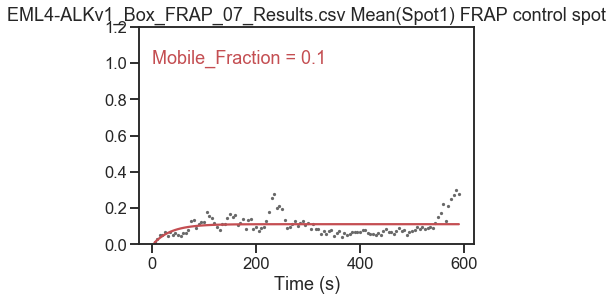

v =  0.9596486271222491
F0 =  -0.05224609157056226


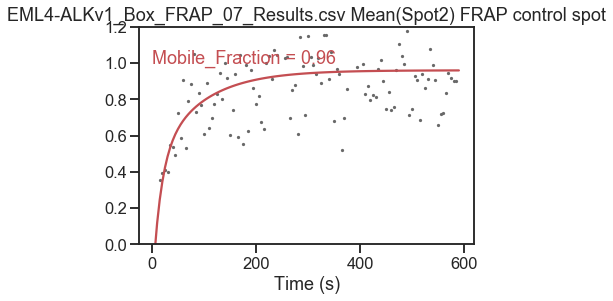

v =  0.8762388102943875
F0 =  0.2365675291163677


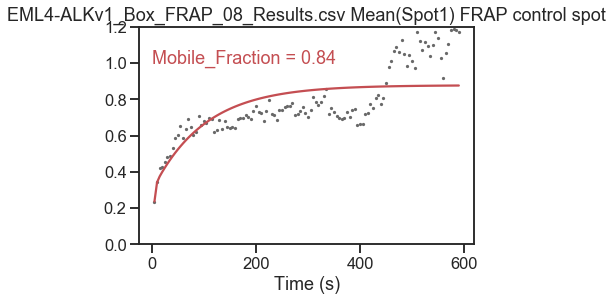

v =  0.5100362088275076
F0 =  0.184885994834943


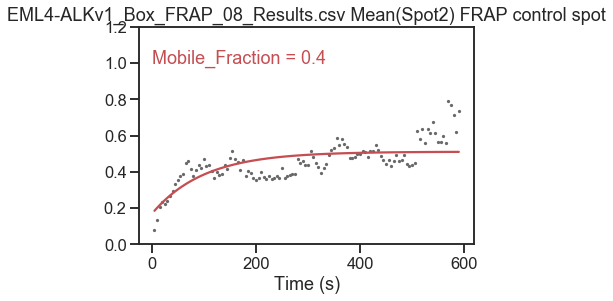

v =  0.4187578406011274
F0 =  0.06731131153619418


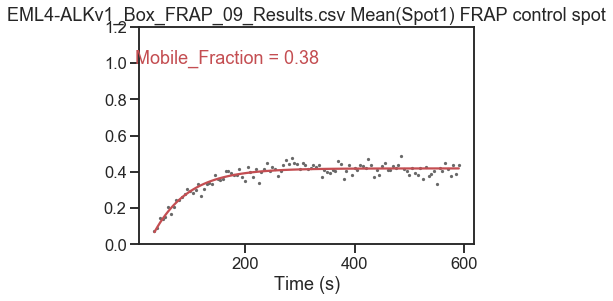

v =  0.3499280308072211
F0 =  0.0776299464221919


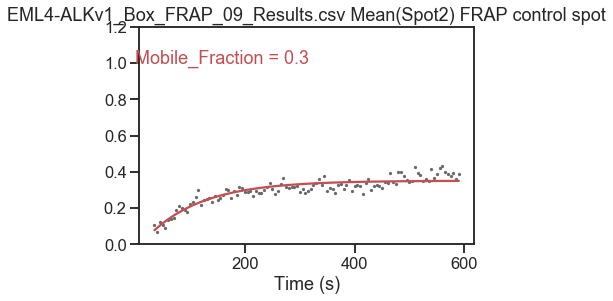

v =  0.7332436555837925
F0 =  0.07573154822487144


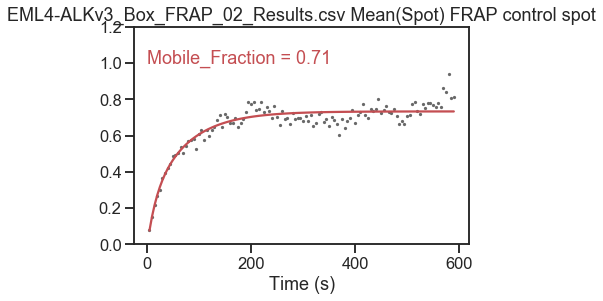

v =  0.3517336469919783
F0 =  0.08675876921474632


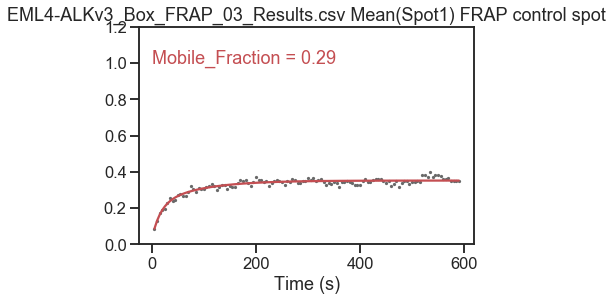

v =  0.28724043207951894
F0 =  0.09270382219375592


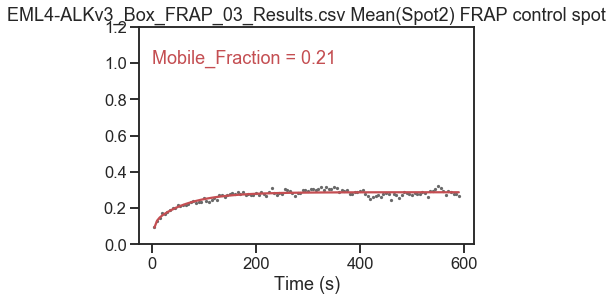

v =  0.5647703092734223
F0 =  0.24198275956616777


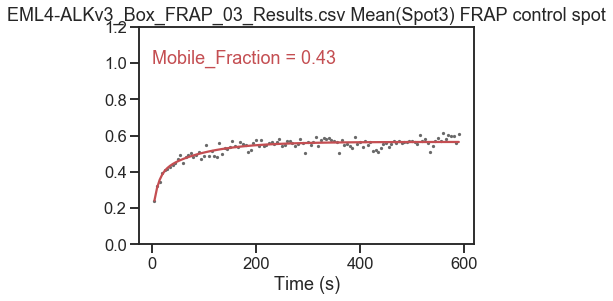

v =  0.8532217799518159
F0 =  0.2221767115300778


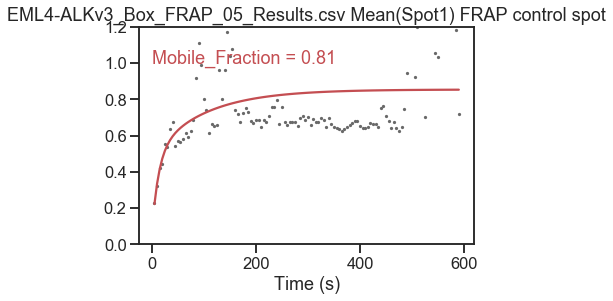

v =  0.5956919025759336
F0 =  0.16498805207761585


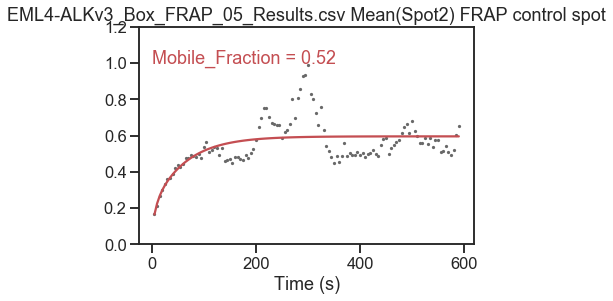

v =  0.44609845606262105
F0 =  -0.005616062441006209


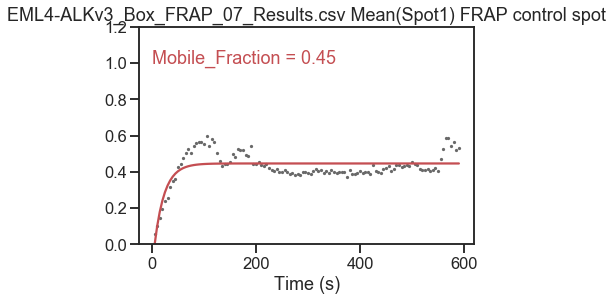

v =  0.7786354687176889
F0 =  0.05035338483713625


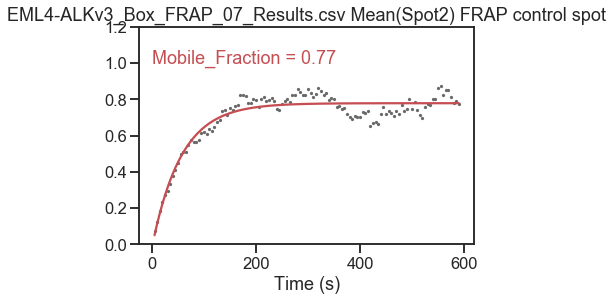

In [107]:
# Fit Surrounding Spots

spot_M_list = list()
column = 1 #Specify the control spot column =1

#Plot all the files
for index in range(len(focus_list)):

    df    = focus_list[index]
    title = focus_list_files[index]
    t0    = focus_file_info.loc[index, 'Bleach Frame']

    sub = subtract_background(df)
    norm = normalise(sub)

    set_time(norm, focus_file_info.loc[file_index, 'fps'])

    FRAP = get_FRAP(norm, t0)


    column_name = FRAP.columns[column]

    x = FRAP['Time']
    y0 = FRAP.iloc[:,column]

    #Plot raw values
    plt.scatter(x, y0, s=3, c='dimgrey');
    
    p0 = [A, B, c, d, h]
    bounds = (0.1, 0.01, 0, 0, 0.01), (1, 1, 100, 100, 1)
    
    y2, p, e = fit_bi_exp(x, y0, p0, bounds)
    
    #Plot fit values
    plt.plot(x, y2, c='r');
    
    #Get Mobile Fraction Estimate
    Mobile_Fraction = get_mobile_from_fit(y2)
    
    spot_M_list.append(Mobile_Fraction)
    
    plt.text(0, 1, s='Mobile_Fraction = '+str(round(Mobile_Fraction, 2)), c='r');
    
    plt.title(title+' '+column_name+' FRAP control spot');
    plt.ylim(0,1.2);
    plt.xlabel('Time (s)');
    plt.show()

In [109]:
focus_file_info['Spot Mobile Fraction'] = spot_M_list
focus_file_info

,File,Fixed,Protein,Filename,fps,Bleach Frame,Focus Mobile Fraction,Spot Mobile Fraction
0,0,False,ALKv1,EML4-ALKv1_Box_FRAP_03_Results.csv,0.2,2,0.388554,0.784664
1,1,False,ALKv1,EML4-ALKv1_Box_FRAP_04_Results.csv,0.2,2,0.183474,0.889818
2,2,False,ALKv1,EML4-ALKv1_Box_FRAP_06_Results.csv,0.2,2,0.394448,0.635415
3,2,False,ALKv1,EML4-ALKv1_Box_FRAP_06_Results.csv,0.2,2,0.571578,0.796211
4,3,False,ALKv1,EML4-ALKv1_Box_FRAP_07_Results.csv,0.2,2,0.156337,0.102826
5,3,False,ALKv1,EML4-ALKv1_Box_FRAP_07_Results.csv,0.2,2,0.075803,0.961652
6,4,False,ALKv1,EML4-ALKv1_Box_FRAP_08_Results.csv,0.2,2,0.174201,0.837888
7,4,False,ALKv1,EML4-ALKv1_Box_FRAP_08_Results.csv,0.2,2,0.245484,0.398902
8,5,False,ALKv1,EML4-ALKv1_Box_FRAP_09_Results.csv,1.0,8,0.138267,0.376810
9,5,False,ALKv1,EML4-ALKv1_Box_FRAP_09_Results.csv,1.0,8,0.142309,0.295216


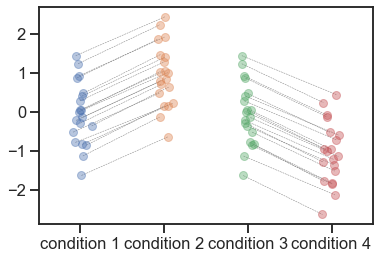

In [111]:
#How to make a paired jitter plot.

N=20
# dummy dataset
data = np.random.normal(size=(N,))
df = pd.DataFrame({'condition 1': data,
                   'condition 2': data+1,
                   'condition 3': data,
                   'condition 4': data-1})

jitter = 0.05
df_x_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=df.values.shape), columns=df.columns)
df_x_jitter += np.arange(len(df.columns))

fig, ax = plt.subplots()
for col in df:
    ax.plot(df_x_jitter[col], df[col], 'o', alpha=.40, zorder=1, ms=8, mew=1)
ax.set_xticks(range(len(df.columns)))
ax.set_xticklabels(df.columns)
ax.set_xlim(-0.5,len(df.columns)-0.5)

for idx in df.index:
    ax.plot(df_x_jitter.loc[idx,['condition 1','condition 2']], df.loc[idx,['condition 1','condition 2']], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)
    ax.plot(df_x_jitter.loc[idx,['condition 3','condition 4']], df.loc[idx,['condition 3','condition 4']], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)

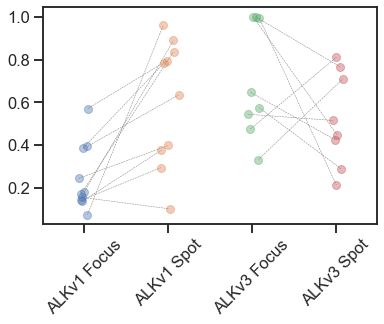

In [114]:
#My paired jitter plot
df = pd.DataFrame({'ALKv1 Focus': focus_file_info[focus_file_info.Protein=='ALKv1']['Focus Mobile Fraction'],
                   'ALKv1 Spot': focus_file_info[focus_file_info.Protein=='ALKv1']['Spot Mobile Fraction'],
                   'ALKv3 Focus': focus_file_info[focus_file_info.Protein=='ALKv3']['Focus Mobile Fraction'],
                   'ALKv3 Spot': focus_file_info[focus_file_info.Protein=='ALKv3']['Spot Mobile Fraction']})

jitter = 0.05
df_x_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=df.values.shape), columns=df.columns)
df_x_jitter += np.arange(len(df.columns))

fig, ax = plt.subplots()
for col in df:
    ax.plot(df_x_jitter[col], df[col], 'o', alpha=.40, zorder=1, ms=8, mew=1)
ax.set_xticks(range(len(df.columns)))
ax.set_xticklabels(df.columns)
ax.set_xlim(-0.5,len(df.columns)-0.5)

for idx in df.index:
    ax.plot(df_x_jitter.loc[idx,['ALKv1 Focus','ALKv1 Spot']], df.loc[idx,['ALKv1 Focus','ALKv1 Spot']], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)
    ax.plot(df_x_jitter.loc[idx,['ALKv3 Focus','ALKv3 Spot']], df.loc[idx,['ALKv3 Focus','ALKv3 Spot']], color = 'grey', linewidth = 0.5, linestyle = '--', zorder=-1)
plt.xticks(rotation=45);

In [79]:
#Mean EML4-ALKv1 Mobile Fraction over ~10 minutes
ALKv1_mean_mobile_fraction = np.array(M_list[0:6]).mean()
ALKv1_mean_mobile_fraction

0.28855903361741636

In [81]:
M_list[6:9]

[0.33562766675757655, 0.6233570617456672, 0.47475313839615785]

In [82]:
#Mean EML4-ALKv3 Mobile Fraction over ~10 minutes
ALKv3_mean_mobile_fraction = np.array(M_list[6:9]).mean()
ALKv3_mean_mobile_fraction

0.4779126222998005

In [110]:
title = focus_list_files[0]
title

'EML4-ALKv1_Box_FRAP_03_Results.csv'

In [114]:
file_info[file_info.Filename==title]['fps'].values[0]

0.2

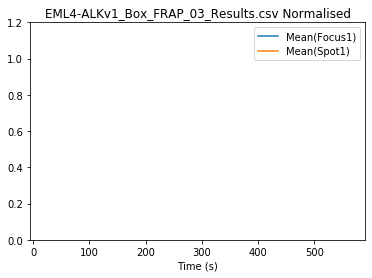

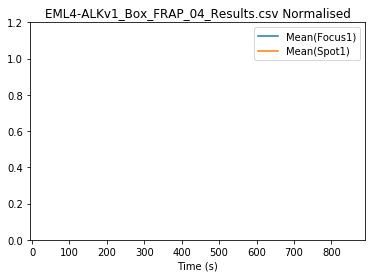

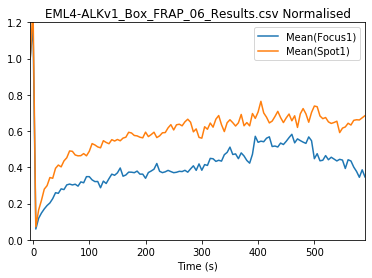

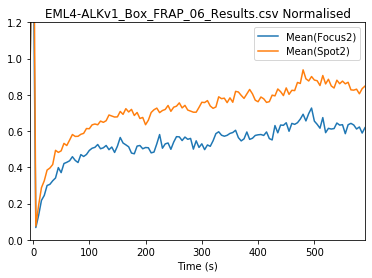

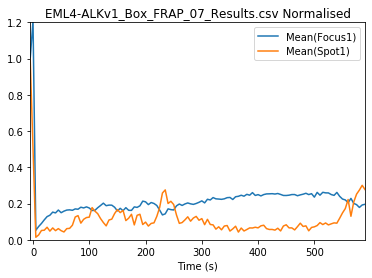

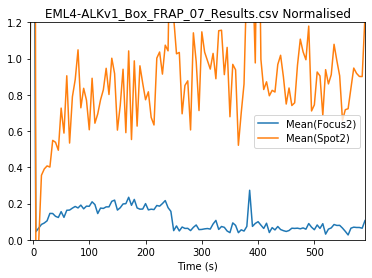

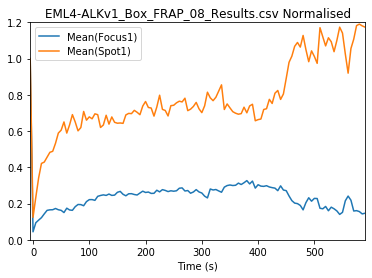

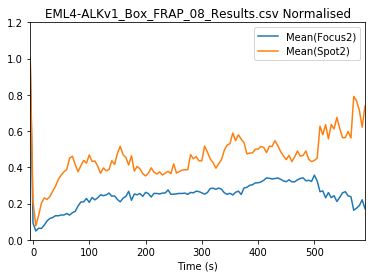

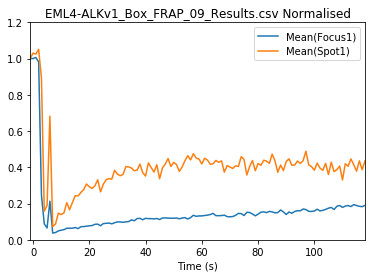

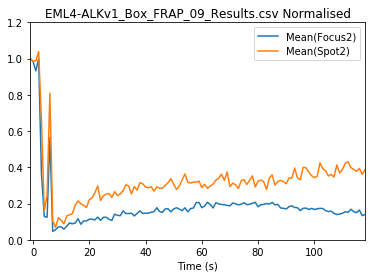

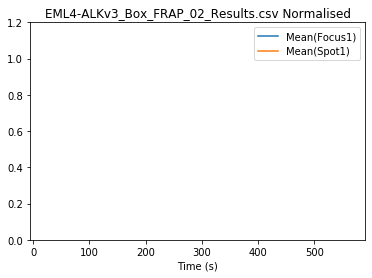

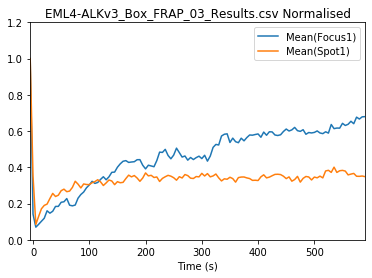

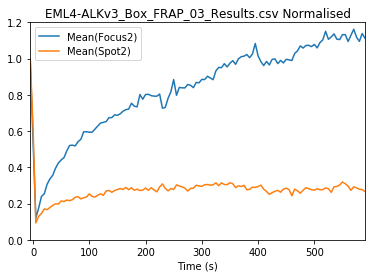

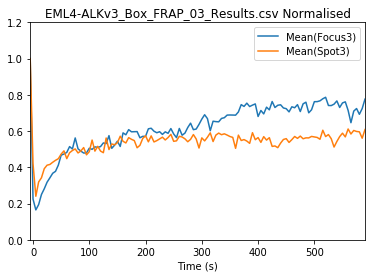

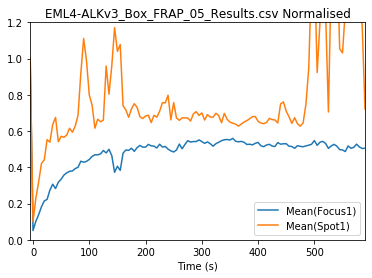

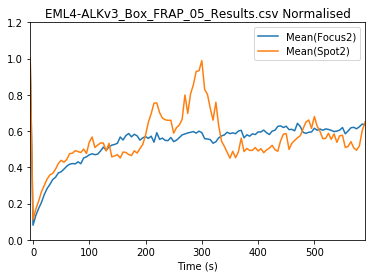

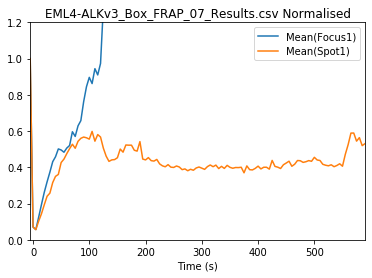

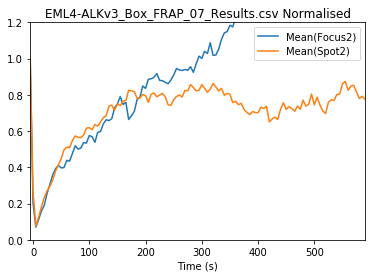

In [115]:
## PLOT ALL THE FOCI
for file_index in range(len(focus_list_files)):
    
    df    = focus_list[file_index]
    title = focus_list_files[file_index]
    
    sub = subtract_background(df)
    norm = normalise(sub)
    
    #Get time
    set_time(norm, file_info[file_info.Filename==title]['fps'].values[0])

    norm.drop(columns=['Frame']).plot(x='Time');
    plt.title(title+' Normalised');
    plt.ylim(0,1.2);
    plt.xlabel('Time (s)');

ValueError: array must not contain infs or NaNs

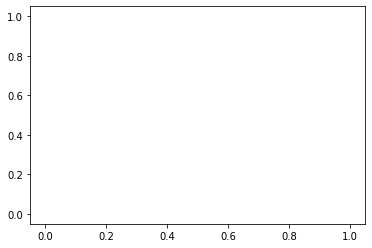

In [101]:



M_list = list()

#Plot all the files
for file_index in range(len(focus_list_files)):
    column = 0

    df    = focus_list[file_index]
    title = focus_list_files[file_index]
    t0    = focus_t0_list[file_index]

    sub = subtract_background(df)
    norm = normalise(sub)

    set_time(norm, file_info.loc[file_index, 'fps'])

    FRAP = get_FRAP(norm, t0)


    column_name = FRAP.columns[column]

    x = FRAP['Time']
    y0 = FRAP.iloc[:,column]

    #Plot raw values
    plt.scatter(x, y0, s=3, c='dimgrey');
    
    p0 = [A, B, c, d, h]
    bounds = (0.1, 0.01, 0, 0, 0.01), (1, 1, 100, 100, 1)
    
    y2, p, e = fit_bi_exp(x, y0, p0, bounds)
    
    #Plot fit values
    plt.plot(x, y2, c='r');
    
    #Get Mobile Fraction Estimate
    Mobile_Fraction = get_mobile_from_fit(y2)
    
    M_list.append(Mobile_Fraction)
    
    plt.text(0, 1, s='Mobile_Fraction = '+str(round(Mobile_Fraction, 2)), c='r');
    
    plt.title(title+' '+column_name+' FRAP');
    plt.ylim(0,1.2);
    plt.xlabel('Time (s)');
    plt.show()

In [53]:
# How do our cells photobleach over time?

In [54]:
for df in df_list:
    if 'Mean(Control_Spot)' in df.columns:
        plt.plot(df['Frame'], df['Mean(Control_Spot)']);

In [55]:
for df in df_list:
    if 'Mean(Control_Spot)' in df.columns:
        
        #normalise_y
        y = (df['Mean(Control_Spot)']-df['Mean(Control_Spot)'].min())/(df.loc[0,'Mean(Control_Spot)']-df['Mean(Control_Spot)'].min())
        
        plt.plot(df['Frame'], y);

In [56]:
# Need to exclude this annomaly

for n, df in enumerate(df_list):
    if 'Mean(Control_Spot)' in df.columns:
        
        #normalise_y
        y = (df['Mean(Control_Spot)']-df['Mean(Control_Spot)'].min())/(df['Mean(Control_Spot)'].max()-df['Mean(Control_Spot)'].min())
        
        if y.max() > 200:
            print('File',n,'-', file_list[n], 'has a control_spot issue')
            
        if np.isnan(y[0]):
            print('File',n,'-', file_list[n], 'gives NaN')
            
        if np.inf() in y:
            print('File',n,'-', file_list[n], 'gives inf')
        
        plt.plot(df['Frame'], y);

In [57]:
# I checked file 73 manually, and the Control Focus moves into the Control Spot ROI.

In [58]:
y_list=list()

for df in df_list:
    if 'Mean(Control_Spot)' in df.columns:
        
        #normalise_y
        y = (df['Mean(Control_Spot)']-df['Mean(Control_Spot)'].min())/(df.loc[0,'Mean(Control_Spot)']-df['Mean(Control_Spot)'].min())
        
        plt.plot(df['Frame'], y);
        plt.ylim(0,1);
        
        y_list.append(y)
        
    y_df = pd.DataFrame(y_list).T

In [59]:
y_df

""


In [60]:
combined_df['Protein'].unique()

NameError: name 'combined_df' is not defined

In [ ]:
#Plot groups of data

In [ ]:
combined_df[combined_df['Protein']=='ALKv1'].index

In [ ]:
df_list[combined_df[combined_df['Protein']=='ALKv1'].index]

In [ ]:
combined_df['Protein']=='ALKv1' and combined_df['Fixed']==False

In [ ]:
for df_index in combined_df[combined_df['Protein']=='ALKv1'].index:
#     print(df_index)
    
    df    = df_list[df_index]
    title = file_list[df_index]
    t0    = t0_frames[df_index]

    sub = subtract_background(df)
    norm = normalise(sub)
    FRAP = get_FRAP(norm, ROI, t0)
    
    x  = FRAP['Time']
    y0 = FRAP['Mean(Focus)']
    A  = 0.7
    c  = 0.6
    h  = 0.24

    p0 = [A, c, h]
    bounds = (0.1, 0.1, 0), (1, 90, 1)
    
    fit, p, e = fit_exp(x, y0, p0, bounds)
    
    plt.scatter(FRAP['Time'], y0)
    plt.plot(FRAP['Time'], fit)
    plt.title('EML4-ALKv1 FRAP');

In [ ]:
combined_df

In [ ]:
combined_df['Corrections'] = 'No notes'

In [ ]:
combined_df['Filename']=='EML4-ALKv1_FRAP_2_Results.csv'

In [ ]:
combined_df[combined_df['Filename']=='EML4-ALKv1_FRAP_2_Results.csv']

In [ ]:
combined_df[combined_df['Experiment']=='Exp003']

In [ ]:
combined_df[(combined_df['Experiment']=='Exp003') & (combined_df['Filename']=='EML4-ALKv1_FRAP_2_Results.csv')]['Corrections']

In [ ]:
combined_df.loc[(combined_df['Experiment']=='Exp003') 
                & (combined_df['Filename']=='EML4-ALKv1_FRAP_2_Results.csv'), 'Corrections'] = 'Really ALKv3'

In [ ]:
combined_df.loc[(combined_df['Experiment']=='Exp003') 
                & (combined_df['Filename']=='EML4-ALKv3_FRAP_06_Results.csv'), 'Corrections'] = 'Same Cell as EML4-ALKv3_FRAP_01_Results.csv'

combined_df.loc[(combined_df['Experiment']=='Exp003') 
                & (combined_df['Filename']=='EML4-ALKv3_FRAP_01_Results.csv'), 'Corrections'] = 'Same Cell as EML4-ALKv3_FRAP_06_Results.csv'

In [ ]:
combined_df.loc[(combined_df['Experiment']=='Exp003') 
                & (combined_df['Filename']=='EML4-ALKv1_FRAP_2_Results.csv'), 'Corrections'] = 'Really ALKv3'

In [ ]:
combined_df[combined_df['Experiment']=='Exp004']

In [ ]:
FRAP_list = list()

for df_index in combined_df[(combined_df['Protein']=='ALKv1') &
                           (combined_df['Fixed']==False)].index:
#     print(df_index)
    
    df    = df_list[df_index]
    title = file_list[df_index]
    t0    = t0_frames[df_index]

    sub = subtract_background(df)
    norm = normalise(sub)
    FRAP = get_FRAP(norm, ROI, t0)
    
    #Set time as index to allow alignment
    FRAP.set_index(FRAP.Time, inplace=True)
    FRAP_curve = FRAP[ROI]
    
    #Propagate the experiment title
    FRAP_curve.name = title
    FRAP_list.append(FRAP_curve)
    
FRAP_df = pd.concat(FRAP_list, axis=1) 

In [ ]:
FRAP_df

In [ ]:
FRAP_df.plot(legend=None);

In [ ]:
def get_FRAP_df(combined_df, protein, fix=False):

    FRAP_list = list()

    for df_index in combined_df[(combined_df['Protein']==protein) &
                               (combined_df['Fixed']==fix)].index:
    #     print(df_index)

        df    = df_list[df_index]
        title = file_list[df_index]
        t0    = t0_frames[df_index]

        sub = subtract_background(df)
        norm = normalise(sub)
        FRAP = get_FRAP(norm, ROI, t0)

        #Set time as index to allow alignment
        FRAP.set_index(FRAP.Time, inplace=True)
        FRAP_curve = FRAP[ROI]

        #Propagate the experiment title
        FRAP_curve.name = df_index
        FRAP_list.append(FRAP_curve)

    FRAP_df = pd.concat(FRAP_list, axis=1)
    
    FRAP_df.plot(legend=None);
    plt.title(protein)

    return FRAP_df


In [ ]:
fixed_ALKv1_FRAP_df = get_FRAP_df(combined_df, protein='ALKv1', fix=True)
plt.ylim(0,1);

In [ ]:
ALKv1_FRAP_df = get_FRAP_df(combined_df, protein='ALKv1')
plt.ylim(0,1);

In [ ]:
file_list.index('EML4-ALKv1_FRAP_08_Results.csv')

In [ ]:
t0_frames

In [ ]:
combined_df.iloc[62,:]

In [ ]:
ALKv3_FRAP_df = get_FRAP_df(combined_df, protein='ALKv3')
plt.ylim(0,1);

In [ ]:
ALKv5_FRAP_df = get_FRAP_df(combined_df, protein='ALKv5')
plt.ylim(0,1);

In [ ]:
ALKv5_FRAP_df

In [ ]:
Ret_FRAP_df = get_FRAP_df(combined_df, protein='Ret')
plt.ylim(0,1);

In [ ]:
#Use a sequential colourmap

In [ ]:
ALKv1_FRAP_df.plot(legend=None, cmap="BuPu");

In [ ]:
Ret_FRAP_df.plot(legend=None, cmap="BuPu");

In [ ]:
## Colour by trait

In [ ]:
combined_df[combined_df['File']==2]['Initial_Focus']

In [ ]:
combined_df.loc[combined_df['File']==2,'Initial_Focus']

In [ ]:
combined_df.loc[combined_df['File']==2,'Initial_Focus'].values[0]

In [ ]:
#get trait by filename
#Let's start with initial focus intensity

def get_trait_list(combined_df, FRAP_df, trait_name):

    trait_list=list()

    for df_index in FRAP_df.columns:

        trait=combined_df[combined_df['File']==df_index][trait_name].values[0]

        trait_list.append(trait)

    return trait_list

In [ ]:
trait_name = 'Initial_Focus'

trait_list = get_trait_list(combined_df, ALKv1_FRAP_df, trait_name)

trait_array = np.array(trait_list)

trait_array.argsort()

ALKv1_FRAP_df.iloc[:,trait_array.argsort()].plot(legend=None, c=trait_list, cmap="RdYlBu_r");
plt.title(trait_name);
plt.ylim(0,1);
#Bright foci tend to recover less well

In [ ]:
trait_name = 'Initial_Spot'

trait_list = get_trait_list(combined_df, ALKv1_FRAP_df, trait_name)

trait_array = np.array(trait_list)

trait_array.argsort()

ALKv1_FRAP_df.iloc[:,trait_array.argsort()].plot(legend=None, c=trait_list, cmap="RdYlBu_r");
plt.title(trait_name);
plt.ylim(0,1);
#Higher expression tends to recover better

In [61]:
combined_df.columns

NameError: name 'combined_df' is not defined

In [ ]:
#Focus Relative to Cytoplasm a.k.a. Focus/Spot
combined_df['Initial_Target_Ratio']  = combined_df['Initial_Focus'] / combined_df['Initial_Spot']
combined_df['Initial_Control_Ratio'] = combined_df['Initial_Control_Focus'] / combined_df['Initial_Control_Spot']

In [ ]:
trait_name = 'Initial_Target_Ratio'

trait_list = get_trait_list(combined_df, ALKv1_FRAP_df, trait_name)

trait_array = np.array(trait_list)

ALKv1_FRAP_df.iloc[:,trait_array.argsort()].plot(legend=None, c=trait_list, cmap="RdYlBu_r");
plt.title(trait_name);
plt.ylim(0,1);
#Experiments where the focus is bright relative to the surrounding cytoplasm, tend to recover less fully

#This is consistent with a lower supply of free protein, and a lower surface area to volume ratio of the puncta. 

In [ ]:
#These are the Initial_Target_Ratios for ALKv1
trait_array

In [ ]:
len(trait_array)

In [ ]:
trait_array.mean()

In [ ]:
#What to the low, mid and high fractions look like?
trait_name = 'Initial_Target_Ratio'

trait_list = get_trait_list(combined_df, ALKv1_FRAP_df, trait_name)

trait_array = np.array(trait_list)

ALKv1_FRAP_df.iloc[:,trait_array.argsort()[:12]].plot(legend=None, c='b');
plt.title('Low');
plt.ylim(0,1);
plt.show()

ALKv1_FRAP_df.iloc[:,trait_array.argsort()[12:23]].plot(legend=None, c='y');
plt.title('Mid');
plt.ylim(0,1);
plt.show()

ALKv1_FRAP_df.iloc[:,trait_array.argsort()[23:]].plot(legend=None, c='r');
plt.title('High');
plt.ylim(0,1);
plt.show()

In [ ]:
#Check it is not related to experiment
group1 = list(combined_df[(combined_df.Experiment=='Exp002') & (combined_df.Fixed==False)].index)
group2 = list(combined_df[(combined_df.Experiment=='Exp003') & (combined_df.Fixed==False)].index)
group3 = list(combined_df[(combined_df.Experiment=='Exp004') & (combined_df.Fixed==False)].index)

ALKv1_FRAP_df.loc[:,group1].plot(legend=None, c='magenta');
plt.title('Exp002');
plt.ylim(0,1);
plt.show()

ALKv1_FRAP_df.loc[:,group2].plot(legend=None, c='cyan');
plt.title('Exp003');
plt.ylim(0,1);
plt.show()

ALKv1_FRAP_df.loc[:,group3].plot(legend=None, c='green');
plt.title('Exp004');
plt.ylim(0,1);
plt.show()

In [ ]:
## What about absolute recovery?

In [ ]:
df_index=7

df    = df_list[df_index]
title = file_list[df_index]
t0    = t0_frames[df_index]

sub = subtract_background(df)

#slice after t0 and subtract t0
real = sub[t0:].copy()

#add time in seconds
real['Time'] = (real['Frame']-t0)

#index by time
real.set_index(real.Time, inplace=True)

real = real.subtract(real.iloc[0,:])
real.drop(columns=['Frame', 'Time'], inplace=True)
    
real

In [ ]:
real.plot();

In [ ]:
protein = 'ALKv1'
fix = False

real_list = list()

for df_index in combined_df[(combined_df['Protein']==protein) &
                           (combined_df['Fixed']==fix)].index:
#     print(df_index)

    df    = df_list[df_index]
    title = file_list[df_index]
    t0    = t0_frames[df_index]

    sub = subtract_background(df)
  
    #slice after t0 and subtract t0
    real = sub[t0:].copy()

    #add time in seconds
    real['Time'] = (real['Frame']-t0)

    #index by time
    real.set_index(real.Time, inplace=True)

    real = real.subtract(real.iloc[0,:])
    real.drop(columns=['Frame', 'Time'], inplace=True)

    real_curve = real[ROI]

    #Propagate the experiment index
    real_curve.name = df_index
    real_list.append(real_curve)

real_df = pd.concat(real_list, axis=1)

real_df.plot(legend=None);
plt.title(protein + ' Absolute Recovery');

In [ ]:
trait_name = 'Initial_Focus'

trait_list = get_trait_list(combined_df, real_df, trait_name)

trait_array = np.array(trait_list)

real_df.iloc[:,trait_array.argsort()].plot(legend=None, c=trait_list, cmap="RdYlBu_r");
plt.title(trait_name);
#Brighter the initial puncta tend to have a greater absolute recovery

In [ ]:
trait_name = 'Initial_Spot'

trait_list = get_trait_list(combined_df, real_df, trait_name)

trait_array = np.array(trait_list)

real_df.iloc[:,trait_array.argsort()].plot(legend=None, c=trait_list, cmap="RdYlBu_r");
plt.title(trait_name);
#Brighter the initial cytoplasm tends to give a greater absolute recovery

In [ ]:
trait_name = 'Initial_Target_Ratio'

trait_list = get_trait_list(combined_df, real_df, trait_name)

trait_array = np.array(trait_list)

real_df.iloc[:,trait_array.argsort()].plot(legend=None, c=trait_list, cmap="RdYlBu_r");
plt.title(trait_name);
# Absolute recovery is less dependent upon Initial_Target_Ratio 
# foci closer to their surrounding in intensity (e.g. small foci) still tend to recover faster.

In [ ]:
#Let's look at the limiting cases?

In [ ]:
trait_array.argsort()

In [ ]:
combined_df[(combined_df.Protein=='ALKv1') & (combined_df.Fixed==False)].sort_values('Initial_Target_Ratio')

In [ ]:
#The limiting cases are good enought to support this conclusion.

In [ ]:
#Plot t1/2 against different traits

In [ ]:
ALKv1_FRAP_df[0]

In [ ]:
#get frap
example_frap = ALKv1_FRAP_df[3]

example_frap.plot();
plt.ylim(0,1);

In [ ]:
type(FRAP)

In [ ]:
x = FRAP['Time']
y0 = FRAP[ROI]

In [ ]:
FRAP

In [ ]:
ALKv1_FRAP_df

In [ ]:
ALKv1_FRAP_df.loc[:,0]

In [ ]:
test = pd.DataFrame()
test['Time'] = ALKv1_FRAP_df.index
test.set_index(test['Time'], inplace=True)
test['Test']=ALKv1_FRAP_df.loc[:,0]
test

In [ ]:
compare_fits(test, 'Test')

In [ ]:
#get_thalf



In [ ]:
trait_name = 'Initial_Target_Ratio'

trait_list = get_trait_list(combined_df, ALKv3_FRAP_df, trait_name)

trait_array = np.array(trait_list)

ALKv3_FRAP_df.iloc[:,trait_array.argsort()].plot(legend=None, c=trait_list, cmap="RdYlBu_r");
plt.title(trait_name);
plt.ylim(0,1);
#Experiments where the focus is bright relative to the surrounding cytoplasm, tend to recover less fully

#Less obvious for ALKv3 - predicting a less apparent core-shell structure

In [ ]:
trait_name = 'Initial_Target_Ratio'

trait_list = get_trait_list(combined_df, Ret_FRAP_df, trait_name)

trait_array = np.array(trait_list)

Ret_FRAP_df.iloc[:,trait_array.argsort()].plot(legend=None, c=trait_list, cmap="RdYlBu_r");
plt.title(trait_name);
plt.ylim(0,1);

In [ ]:
trait_list

In [ ]:
trait_array = np.array(trait_list)
trait_array

In [ ]:
trait_array.sort()
trait_array

In [ ]:
trait_array.argsort()

In [ ]:
trait_name = 'Experiment'

In [ ]:
combined_df.columns

In [ ]:
#Convert categories to numeric code
index, labels = combined_df.Protein.factorize()
index

In [ ]:
trait_name = 't0_Control_Focus'

trait_list = get_trait_list(combined_df, ALKv1_FRAP_df, trait_name)

ALKv1_FRAP_df.plot(legend=None, c=trait_list, cmap="RdYlBu_r");
plt.title(trait_name);

In [ ]:
trait_name = 't0_Control_Spot'

trait_list = get_trait_list(combined_df, ALKv1_FRAP_df, trait_name)

ALKv1_FRAP_df.plot(legend=None, c=np.array(trait_list), cmap="RdYlBu_r");
plt.title(trait_name);

In [ ]:
cm = plt.cm.get_cmap('RdYlBu_r')
xy = range(20)
z = xy
sc = plt.scatter(xy, xy, c=z, vmin=0, vmax=20, s=35, cmap=cm)
plt.colorbar(sc)
plt.show()


In [ ]:
trait_array = np.array(trait_list)

In [ ]:
print(trait_array.min(), trait_array.max())

In [ ]:
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.plot(ALKv1_FRAP_df, c=trait_list, cmap=cm);
plt.colorbar(sc)
plt.show()

In [ ]:
cm = plt.cm.get_cmap('RdYlBu')
sc = ALKv1_FRAP_df.plot(legend=None, c=trait_list, vmin=100, vmax=4000, cmap=cm);
plt.colorbar(sc)
plt.show()

In [ ]:
## Plot mean recoveries

In [ ]:
ALKv1_FRAP_df.mean(axis=1).plot()
plt.ylim(0,1);

In [ ]:
ALKv3_FRAP_df.mean(axis=1).plot()
plt.ylim(0,1);

In [ ]:
ALKv5_FRAP_df.mean(axis=1).plot()
plt.ylim(0,1);

In [ ]:
Ret_FRAP_df.mean(axis=1).plot()
plt.ylim(0,1);

In [ ]:
fixed_ALKv1_FRAP_df.mean(axis=1).plot();
ALKv1_FRAP_df.mean(axis=1).plot();
ALKv3_FRAP_df.mean(axis=1).plot();
ALKv5_FRAP_df.mean(axis=1).plot();
Ret_FRAP_df.mean(axis=1).plot();
plt.legend(['fixed', 'v1', 'v3', 'v5', 'Ret']);

In [ ]:
file_list[36]

In [ ]:
t0_frames[36]

In [ ]:
df_index = 32

df    = df_list[df_index]
title = file_list[df_index]
t0    = t0_frames[df_index]

sub = subtract_background(df)
norm = normalise(sub)
FRAP = get_FRAP(norm, ROI, t0)

sub.plot(x='Frame');
plt.axvline(t0);
plt.xlim(t0-4, t0+4);

In [ ]:
#df 36 t0 is 11 not 10.

In [ ]:
#Aggregate Data from summary

FRAP_mean = pd.DataFrame()
FRAP_mean['Time']=range(100)

for df_index in combined_df[combined_df['Protein']=='ALKv1'].index:
#     print(df_index)
    
    df    = df_list[df_index]
    title = file_list[df_index]
    t0    = t0_frames[df_index]

    sub = subtract_background(df)
    norm = normalise(sub)
    FRAP = get_FRAP(norm, ROI, t0)
    FRAP.set_index(FRAP.Time, inplace=True)
    
#     FRAP_mean.merge(FRAP[ROI], how='outer', left_index=True, right_index=True)
    FRAP_mean.join(FRAP[ROI], how='outer')

FRAP_mean

In [ ]:
df_index = 12

df    = df_list[df_index]
title = file_list[df_index]
t0    = t0_frames[df_index]

sub = subtract_background(df)
norm = normalise(sub)
FRAP = get_FRAP(norm, ROI, t0)

#Index by Time
FRAP.set_index(FRAP.Time, inplace=True)
FRAP

In [ ]:
FRAP_mean.merge(FRAP, 'outer')
